# PIGPVAE model
The main difference to traditional VAE model (Kigma et al., 2014) is that instead of using standard gaussian distibutions on the latent vector $\mathbf{Z} = [\mathbf{z}_1, \ldots, \mathbf{z}_L],$ where $\mathbf{z}_l \sim \mathcal{N}(0, \sigma^2I),$ we use GPs that account for the depedency that we have in time. Therefore we have that $\mathbf{z}_l \sim \mathcal{N}(0, K(t,t'\mid \theta_l)),$ where $K$ is a function that models the correlation that we have in time. 

This is in principle a conditional (in time) generator. Another advantage of using GPs for the latent variables, is that we do not need the data to be equally spaced in time. It is also possible to condition on other features. For example, the outer temperature, solar irradiance, wind, ...

The main drawback with GPs is the cubic in data $\mathcal{O}(N^3)$ cost and the vanilla GP model can not be trained in mini-batches.
To overcome the cost we can use reliable approximations (e.g. Titsias 2009) that reduce the cost to $\mathcal{O}(Nm^2),$ where $m$ is a user the number of so called inducing points (user choice, usually 20-30 is fine). At the same time there are two recent papers that make GPs ammenable to mini-batching (add refs).

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm
import tsgm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sys.path.append(os.path.abspath('..'))
from physics import NewtonsLaw
from GP import *

# from Models.PIGPVAE_heating import PIGPVAE
from Models.PIGPVAE_lognorm import PIGPVAE
from VAE_utils import AnnealingStrategy
import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
#  define surrounding temperature
df.loc[:, 'sur_temp'] = (df['RTD420'] + df['RTD417'] + df['B.ASTRHT2.T'])/3 
df_h = df.copy()
df_h = df[df['temp_change_class'] == 'h']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
df_h = df_h.dropna()

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_97020/3580172856.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
class RICO4Dataset(Dataset):
    def __init__(self, df, select_var, exclude_samples=None):
        """
        Args:
            df: DataFrame containing the data.
            select_var: List of variables to include in the dataset.
            exclude_samples: List of samples (intervals) to exclude from the dataset.
        """
        self.df = df
        self.select_var = select_var
        if exclude_samples:
            self.unique_batches = [batch for batch in df['interval'].unique() if batch not in exclude_samples]
        else:
            self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch

# Initialize the dataset, excluding samples 53 and 5
exclude_samples = [53, 5]
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset = RICO4Dataset(df_h, select_var, exclude_samples=exclude_samples)

# Validate the updated dataset
print(f"Dataset length after exclusion: {len(dataset)}")


# Define split ratios
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Define a fixed seed for reproducibility

seed = 0
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

Dataset length after exclusion: 29


In [4]:
# Remove rows where 'interval' is 53 or 5 from df_h
excluded_intervals = [53, 5]

# Filter the DataFrame
df_h_filtered = df_h[~df_h['interval'].isin(excluded_intervals)].reset_index(drop=True)

# Display the first few rows of the filtered DataFrame to confirm
# print(df_h_filtered.head())

# Optionally, update df_h with the filtered DataFrame
df_h = df_h_filtered


In [5]:
# Iterate over each unique interval and plot B.RTD1 and sur_temp for that sample
"""
for idx, unique_batch in enumerate(dataset.unique_batches):
    # Extract data for the current batch
    batch_data = dataset[idx]
    time_within_interval = batch_data[:, 2].numpy()  # 'time_within_interval'
    B_RTD1 = batch_data[:, 0].numpy()               # 'B.RTD1'
    sur_temp = batch_data[:, 1].numpy()             # 'sur_temp'
    
    # Create a plot for the current sample
    plt.figure(figsize=(10, 6))
    plt.plot(time_within_interval, B_RTD1, 'o-', label='B.RTD1', alpha=0.7)
    plt.plot(time_within_interval, sur_temp, 'o-', label='Surrounding Temperature (sur_temp)', alpha=0.7)
    plt.xlabel('Time Within Interval')
    plt.ylabel('Values')
    plt.title(f'Sample {unique_batch}: B.RTD1 and Surrounding Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()
"""


"\nfor idx, unique_batch in enumerate(dataset.unique_batches):\n    # Extract data for the current batch\n    batch_data = dataset[idx]\n    time_within_interval = batch_data[:, 2].numpy()  # 'time_within_interval'\n    B_RTD1 = batch_data[:, 0].numpy()               # 'B.RTD1'\n    sur_temp = batch_data[:, 1].numpy()             # 'sur_temp'\n    \n    # Create a plot for the current sample\n    plt.figure(figsize=(10, 6))\n    plt.plot(time_within_interval, B_RTD1, 'o-', label='B.RTD1', alpha=0.7)\n    plt.plot(time_within_interval, sur_temp, 'o-', label='Surrounding Temperature (sur_temp)', alpha=0.7)\n    plt.xlabel('Time Within Interval')\n    plt.ylabel('Values')\n    plt.title(f'Sample {unique_batch}: B.RTD1 and Surrounding Temperature')\n    plt.legend()\n    plt.grid(True)\n    plt.show()\n"

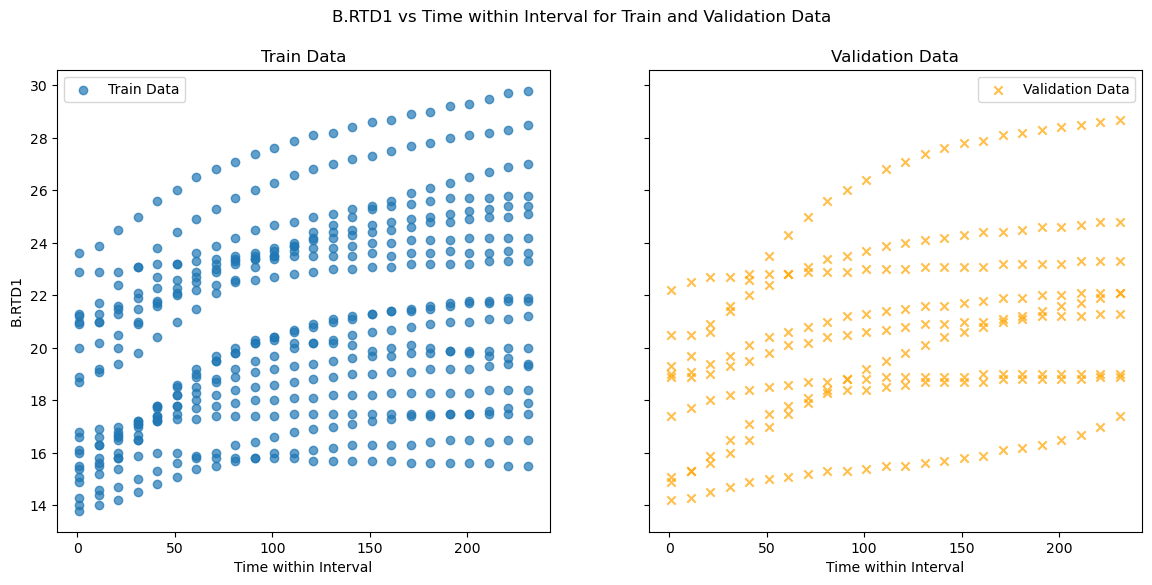

In [6]:
# Initialize lists to store train and validation data
train_time, train_heat = [], []
val_time, val_heat = [], []

# Collect data from train_loader
for batch in train_loader:
    # Extract `time_within_interval` and `B.RTD1` from each batch
    heat_obs = batch[0][:, 0].numpy()  # B.RTD1
    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale
    
    # Append to lists
    train_heat.extend(heat_obs)
    train_time.extend(time_within_interval)

# Collect data from val_loader
for batch in val_loader:
    # Extract `time_within_interval` and `B.RTD1` from each batch
    heat_obs = batch[0][:, 0].numpy()  # B.RTD1
    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale
    
    # Append to lists
    val_heat.extend(heat_obs)
    val_time.extend(time_within_interval)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot training data with markers only
axes[0].scatter(train_time, train_heat, marker='o', label="Train Data", alpha=0.7)
axes[0].set_title("Train Data")
axes[0].set_xlabel("Time within Interval")
axes[0].set_ylabel("B.RTD1")
axes[0].legend()

# Plot validation data with markers only
axes[1].scatter(val_time, val_heat, marker='x', label="Validation Data", alpha=0.7, color='orange')
axes[1].set_title("Validation Data")
axes[1].set_xlabel("Time within Interval")
axes[1].legend()

plt.suptitle("B.RTD1 vs Time within Interval for Train and Validation Data")
plt.show()


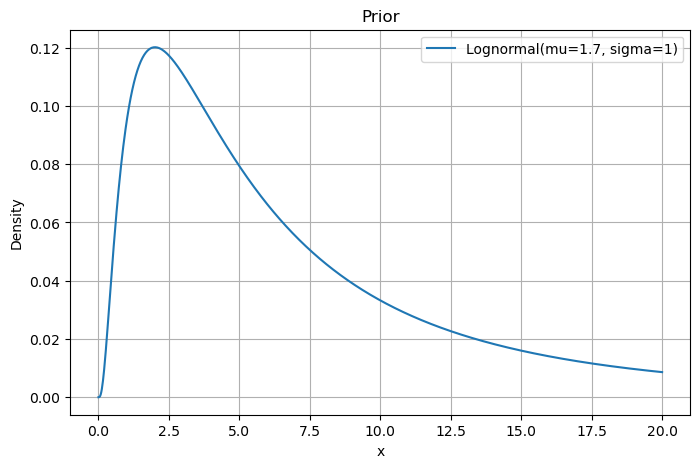

In [7]:

from scipy.stats import lognorm

def plot_single_lognormal(mu, sigma, x_range=(0.01, 20), num_points=1000):
    """
    Plot a single log-normal distribution.

    Parameters:
        mu: Mean of the underlying normal distribution.
        sigma: Standard deviation of the underlying normal distribution.
        x_range: Tuple specifying the range of x values (start, end).
        num_points: Number of points in the x range.
    """
    x = np.linspace(x_range[0], x_range[1], num_points)
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    
    plt.figure(figsize=(8, 5))
    plt.plot(x, pdf, label=f'Lognormal(mu={mu}, sigma={sigma})')
    plt.title('Prior')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_single_lognormal(mu=1.7, sigma=1)


In [8]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)) 
# kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

# Initialize the GP_inference
GP_inf = GP_inference(kernel)

# Initialize the VAE
torch.manual_seed(1)
model = PIGPVAE(GP_inf=GP_inf, 
                hidden_layers_encoder_delta=[10,10], 
                hidden_layers_encoder_phy=[10], 
                hidden_layers_decoder_delta=[10,10],
                activation_decoder_delta=nn.ELU(),
                initial_alpha=1.2,# initial_alpha=1,
                trainable_alpha=True,
                mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
               )

In [9]:
gp_params = []
base_params = []
alpha_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    elif 'raw_alpha' in name:
        alpha_params.append(param)  # raw_alpha parameter(s)
    else:
        base_params.append(param)  # All other parameters

# Define learning rates for each parameter group
base_lr = 0.001     # Learning rate for base parameters
gp_lr = 0.0001      # Learning rate for GP parameters
alpha_lr = 0.0001     # Learning rate for raw_alpha
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr},
    {'params': alpha_params, 'lr': alpha_lr}
])
opt.zero_grad()


In [10]:
"""
def find_rbf_lengthscale(kernel):
    if isinstance(kernel, gpytorch.kernels.RBFKernel):
        return kernel.lengthscale.item()
    elif hasattr(kernel, 'base_kernel'):
        return find_rbf_lengthscale(kernel.base_kernel)
    elif hasattr(kernel, 'kernels'):
        for k in kernel.kernels:
            result = find_rbf_lengthscale(k)
            if result is not None:
                return result
    return None
"""

"\ndef find_rbf_lengthscale(kernel):\n    if isinstance(kernel, gpytorch.kernels.RBFKernel):\n        return kernel.lengthscale.item()\n    elif hasattr(kernel, 'base_kernel'):\n        return find_rbf_lengthscale(kernel.base_kernel)\n    elif hasattr(kernel, 'kernels'):\n        for k in kernel.kernels:\n            result = find_rbf_lengthscale(k)\n            if result is not None:\n                return result\n    return None\n"

In [11]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)


Training Progress:   5%|▍         | 19/400 [00:01<00:36, 10.49it/s]

Epoch 20: Train Loss = 2.2751, KL_phy = 2.4912, KL_delta = -0.3369, MSE = 2.1726, CE = 1.2004, Reg_Loss = 0.0317, Alpha = 1.1928
Validation Loss = 3.7662, Val_KL_phy = 2.4811, Val_KL_delta = -0.3298, Val_MSE = 3.6600, Val_CE = 1.1754, Val_Reg_Loss = 0.0349, Val_Alpha = 1.1926


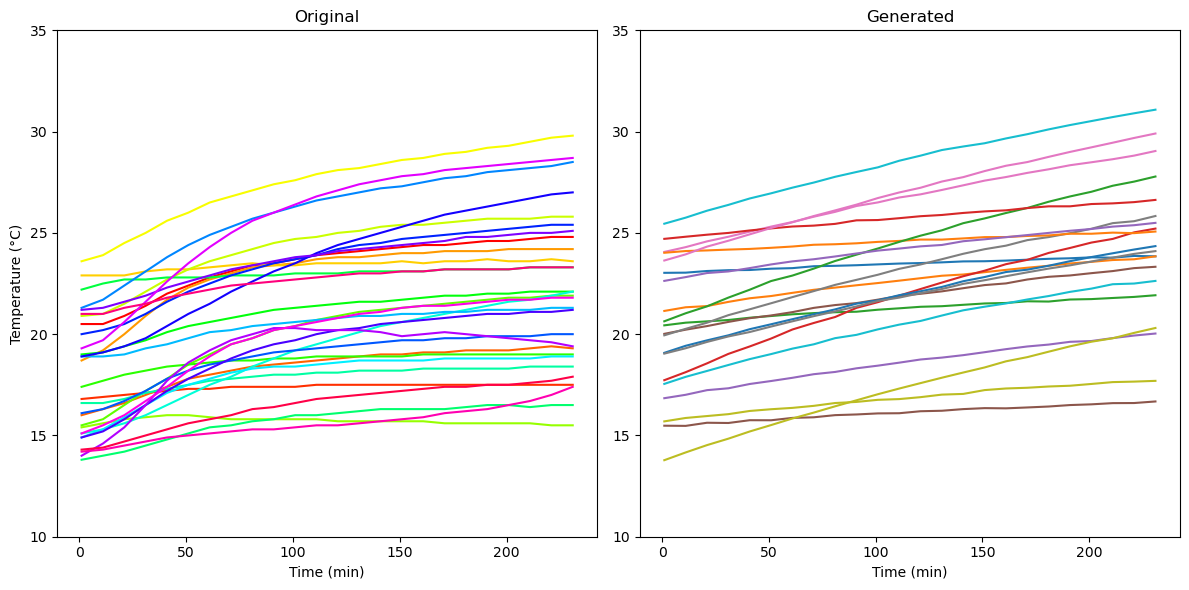

Training Progress:  10%|▉         | 39/400 [00:03<00:34, 10.37it/s]

Epoch 40: Train Loss = 2.7864, KL_phy = 2.4224, KL_delta = -0.1564, MSE = 2.6659, CE = 0.9051, Reg_Loss = 0.0444, Alpha = 1.1819
Validation Loss = 3.0770, Val_KL_phy = 2.4208, Val_KL_delta = -0.1418, Val_MSE = 2.9483, Val_CE = 0.8839, Val_Reg_Loss = 0.0511, Val_Alpha = 1.1816


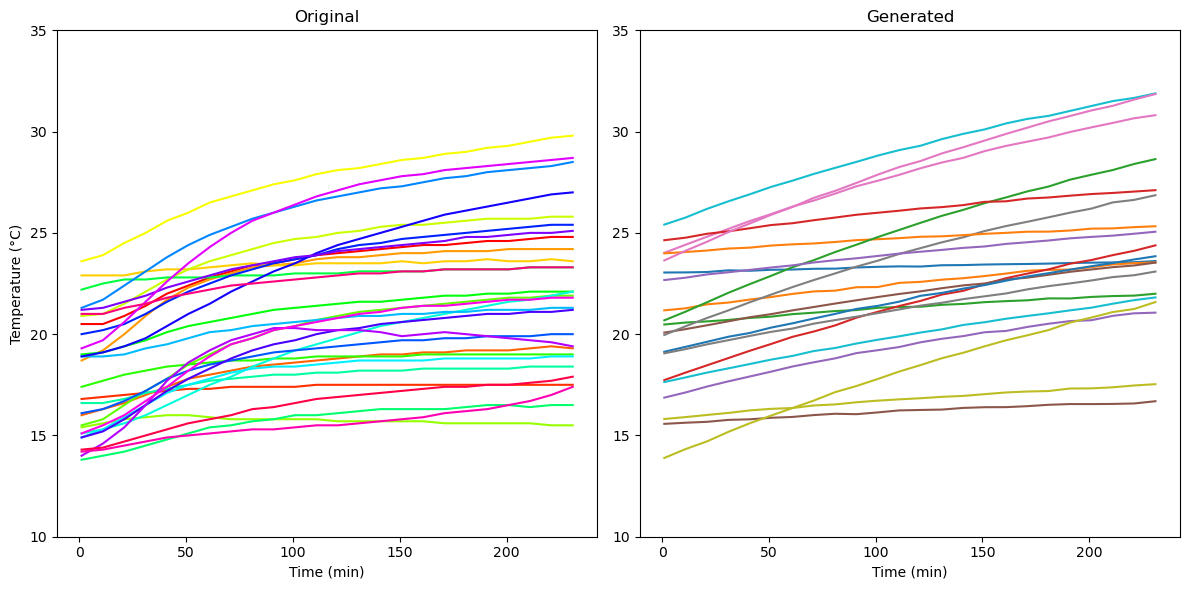

Training Progress:  15%|█▍        | 59/400 [00:06<00:33, 10.27it/s]

Epoch 60: Train Loss = 2.3611, KL_phy = 2.2597, KL_delta = 0.1603, MSE = 2.2363, CE = 0.5828, Reg_Loss = 0.0448, Alpha = 1.1650
Validation Loss = 2.8576, Val_KL_phy = 2.2534, Val_KL_delta = 0.1692, Val_MSE = 2.7161, Val_CE = 0.5823, Val_Reg_Loss = 0.0591, Val_Alpha = 1.1646


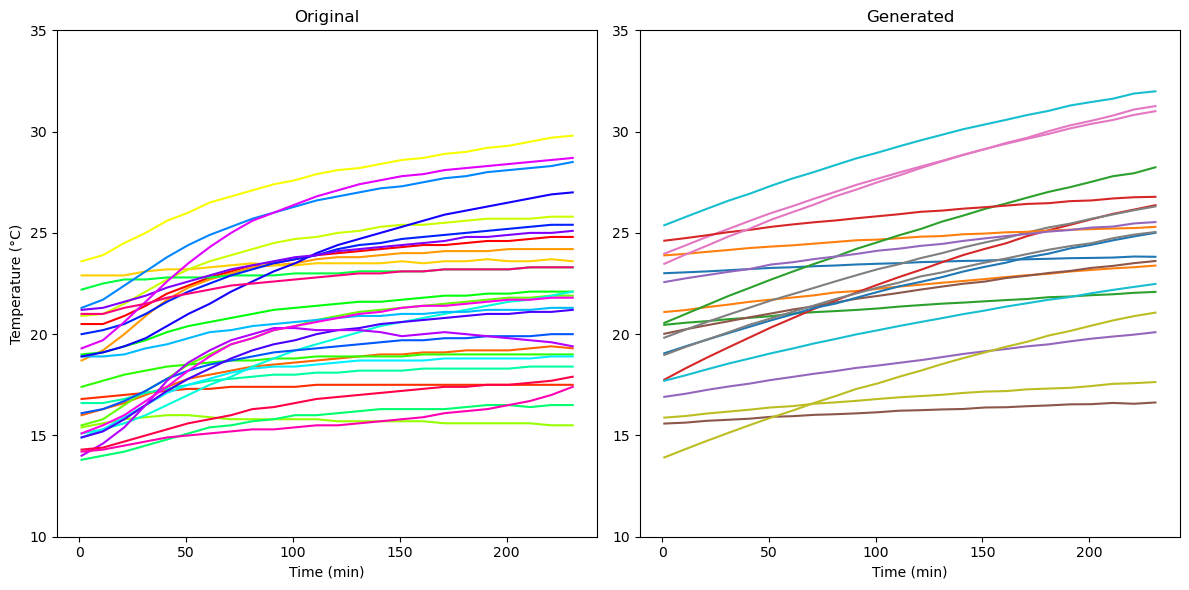

Training Progress:  20%|█▉        | 78/400 [00:08<00:31, 10.36it/s]

Epoch 80: Train Loss = 1.9698, KL_phy = 2.2220, KL_delta = 0.5424, MSE = 1.8205, CE = 0.4191, Reg_Loss = 0.0581, Alpha = 1.1437
Validation Loss = 2.2304, Val_KL_phy = 2.2107, Val_KL_delta = 0.5407, Val_MSE = 2.0708, Val_CE = 0.4286, Val_Reg_Loss = 0.0674, Val_Alpha = 1.1432


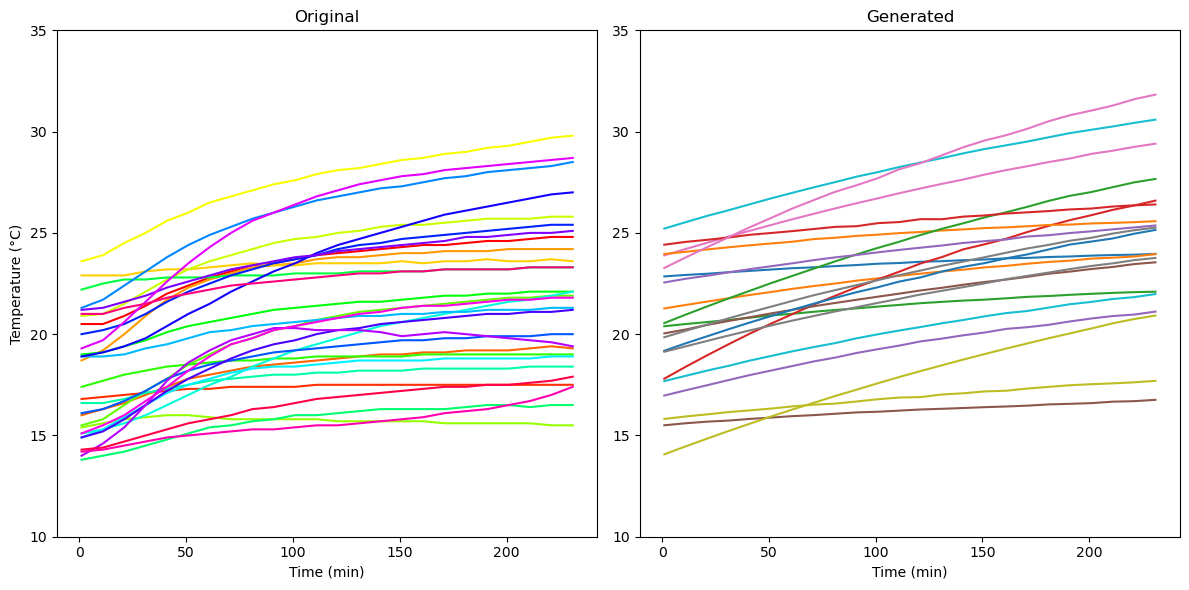

Training Progress:  24%|██▍       | 98/400 [00:10<00:30, 10.00it/s]

Epoch 100: Train Loss = 2.1894, KL_phy = 2.2107, KL_delta = 1.0730, MSE = 1.9955, CE = 0.1668, Reg_Loss = 0.0853, Alpha = 1.1180
Validation Loss = 2.7591, Val_KL_phy = 2.2013, Val_KL_delta = 1.1079, Val_MSE = 2.5230, Val_CE = 0.1566, Val_Reg_Loss = 0.1225, Val_Alpha = 1.1173


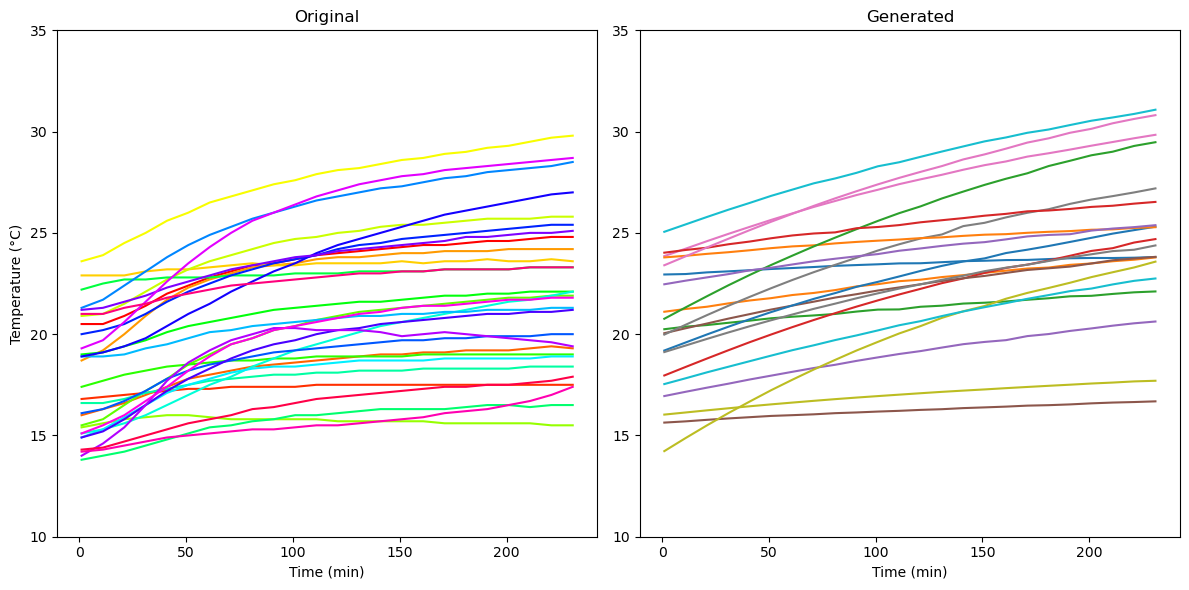

Training Progress:  30%|██▉       | 118/400 [00:12<00:27, 10.30it/s]

Epoch 120: Train Loss = 2.1126, KL_phy = 2.2379, KL_delta = 1.7451, MSE = 1.8704, CE = 0.1238, Reg_Loss = 0.1129, Alpha = 1.0869
Validation Loss = 2.8059, Val_KL_phy = 2.2195, Val_KL_delta = 1.7926, Val_MSE = 2.4984, Val_CE = 0.1155, Val_Reg_Loss = 0.1723, Val_Alpha = 1.0861


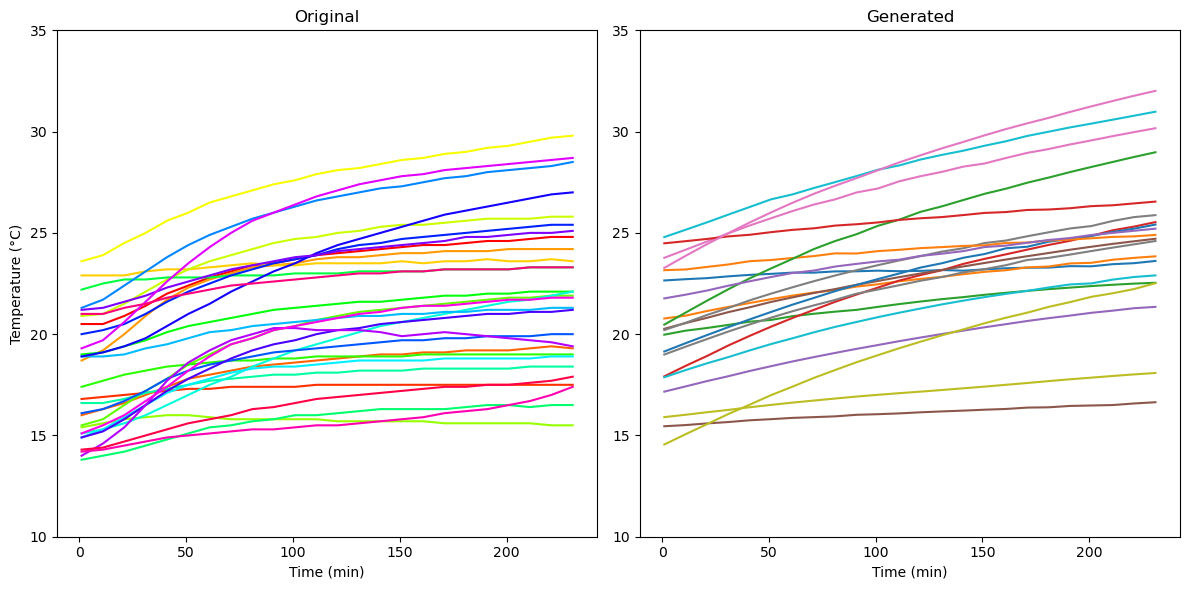

Training Progress:  34%|███▍      | 138/400 [00:14<00:25, 10.38it/s]

Epoch 140: Train Loss = 1.7612, KL_phy = 2.2563, KL_delta = 2.5877, MSE = 1.4200, CE = 0.1014, Reg_Loss = 0.1864, Alpha = 1.0512
Validation Loss = 2.5963, Val_KL_phy = 2.2427, Val_KL_delta = 2.6527, Val_MSE = 2.1644, Val_CE = 0.1002, Val_Reg_Loss = 0.2713, Val_Alpha = 1.0503


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


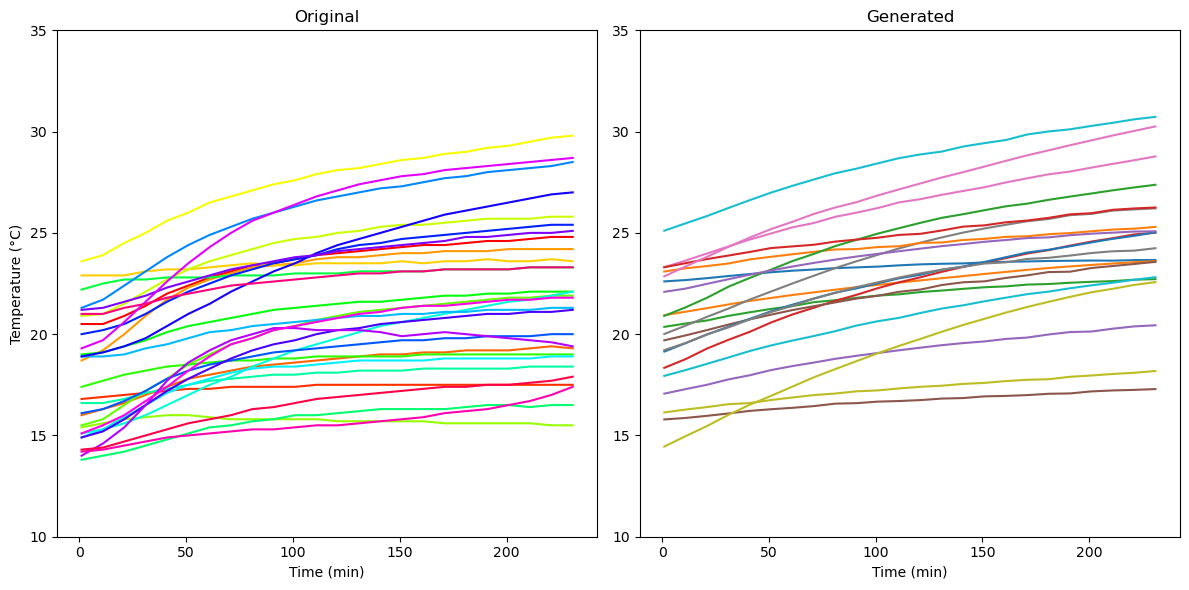

Training Progress:  40%|███▉      | 158/400 [00:16<00:23, 10.32it/s]

Epoch 160: Train Loss = 1.6632, KL_phy = 2.2511, KL_delta = 3.3393, MSE = 1.1867, CE = 0.1278, Reg_Loss = 0.3038, Alpha = 1.0165
Validation Loss = 2.4133, Val_KL_phy = 2.2404, Val_KL_delta = 3.3849, Val_MSE = 1.7539, Val_CE = 0.1256, Val_Reg_Loss = 0.4831, Val_Alpha = 1.0157


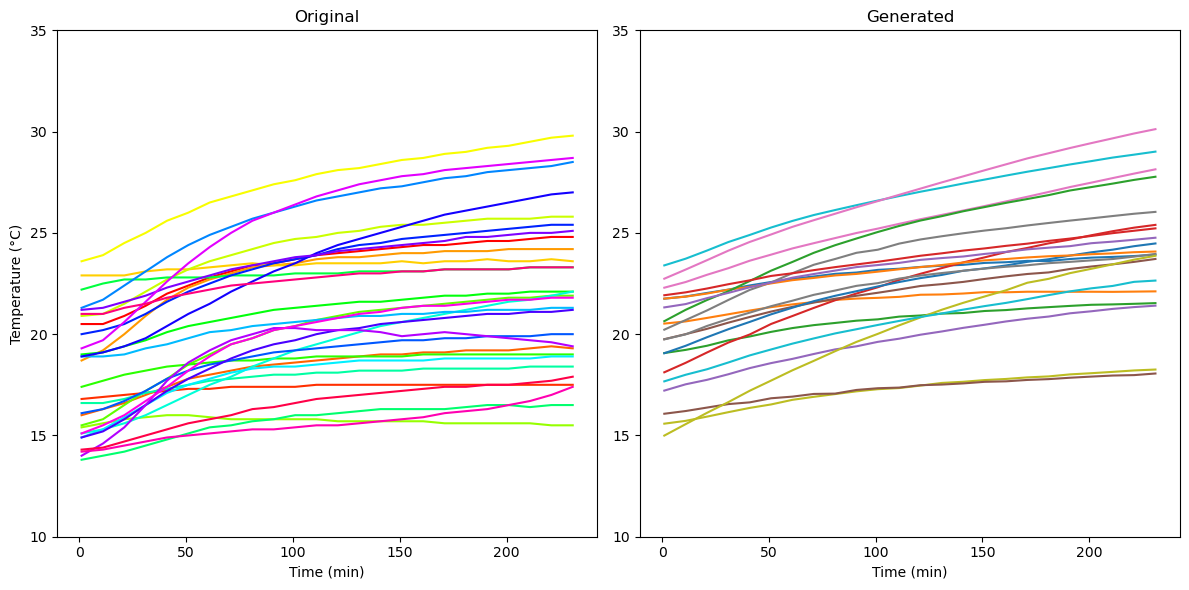

Training Progress:  44%|████▍     | 178/400 [00:18<00:21, 10.32it/s]

Epoch 180: Train Loss = 1.6005, KL_phy = 2.3346, KL_delta = 3.8649, MSE = 1.0076, CE = 0.1540, Reg_Loss = 0.4139, Alpha = 0.9834
Validation Loss = 1.9715, Val_KL_phy = 2.3071, Val_KL_delta = 3.8149, Val_MSE = 1.1958, Val_CE = 0.1436, Val_Reg_Loss = 0.6024, Val_Alpha = 0.9827


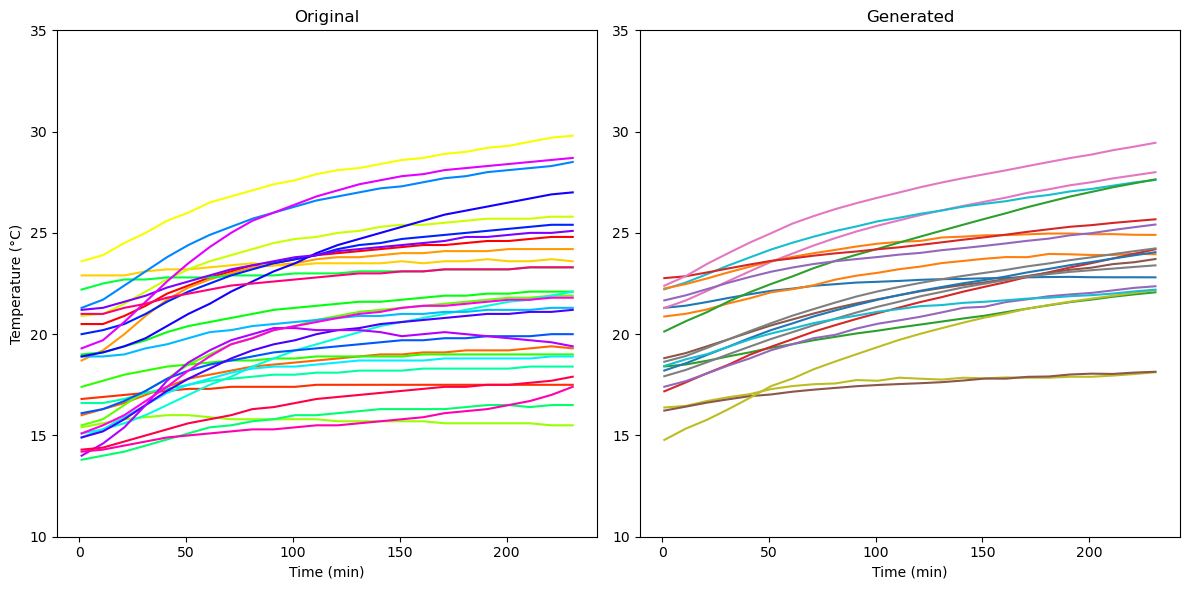

Training Progress:  50%|████▉     | 198/400 [00:20<00:21,  9.38it/s]

Epoch 200: Train Loss = 1.2823, KL_phy = 2.3797, KL_delta = 3.9226, MSE = 0.6750, CE = 0.1642, Reg_Loss = 0.4384, Alpha = 0.9541
Validation Loss = 2.0249, Val_KL_phy = 2.3504, Val_KL_delta = 3.8406, Val_MSE = 1.0828, Val_CE = 0.1590, Val_Reg_Loss = 0.7933, Val_Alpha = 0.9536


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


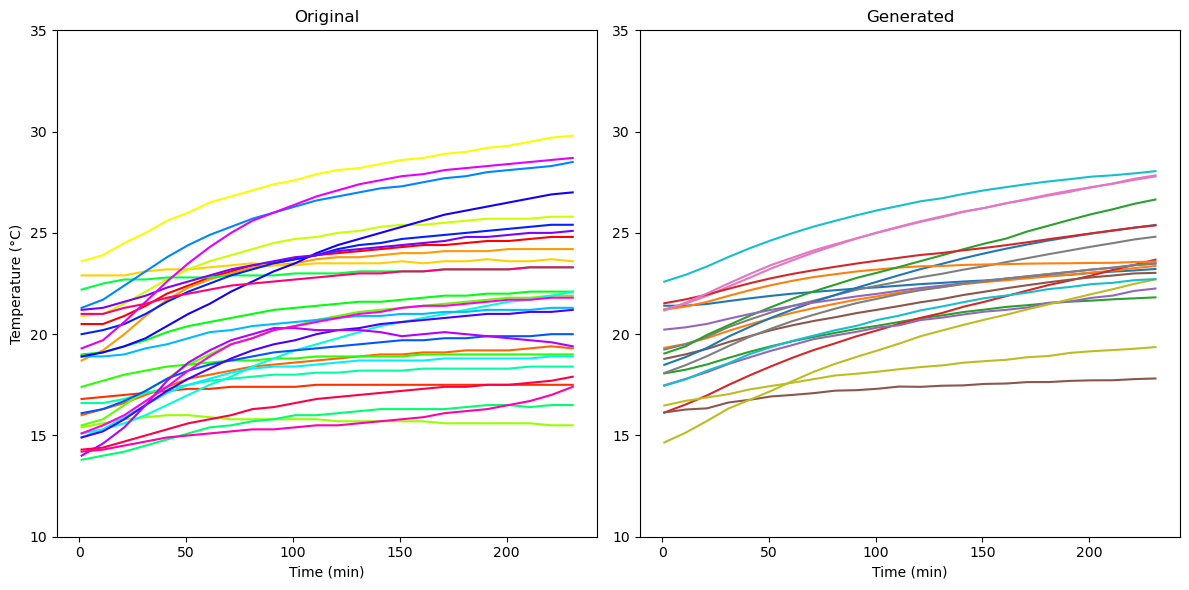

Training Progress:  55%|█████▍    | 218/400 [00:22<00:17, 10.32it/s]

Epoch 220: Train Loss = 1.2891, KL_phy = 2.3768, KL_delta = 3.7034, MSE = 0.6425, CE = 0.1552, Reg_Loss = 0.4993, Alpha = 0.9295
Validation Loss = 1.8539, Val_KL_phy = 2.3603, Val_KL_delta = 3.6069, Val_MSE = 0.9218, Val_CE = 0.1448, Val_Reg_Loss = 0.8106, Val_Alpha = 0.9290


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


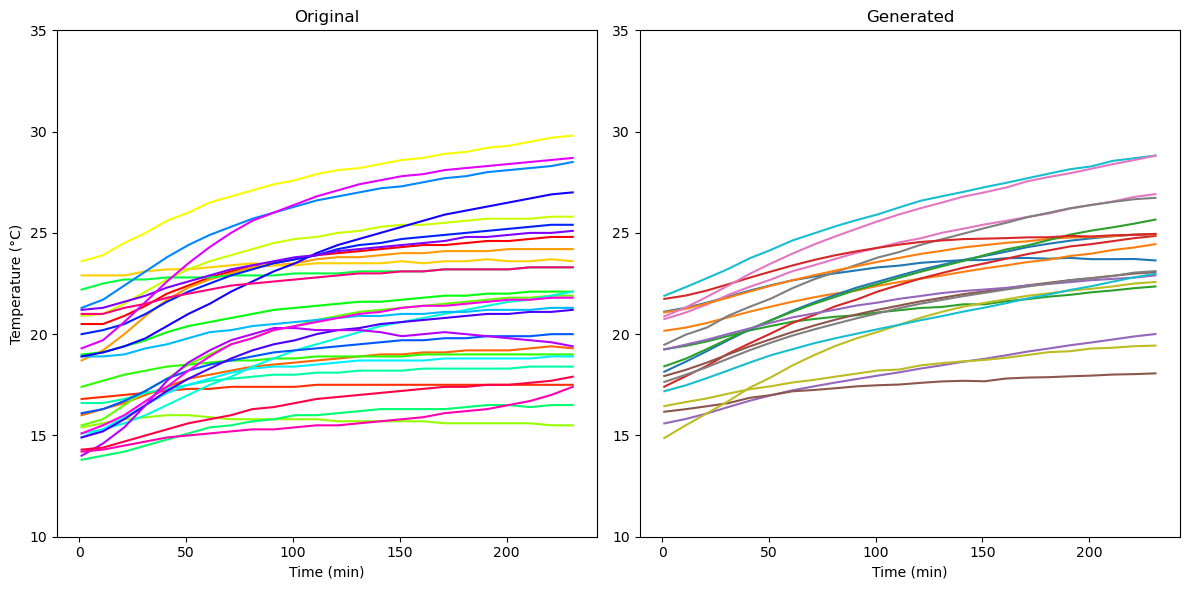

Training Progress:  60%|█████▉    | 238/400 [00:24<00:15, 10.33it/s]

Epoch 240: Train Loss = 1.4043, KL_phy = 2.4756, KL_delta = 3.4477, MSE = 0.7358, CE = 0.1587, Reg_Loss = 0.5405, Alpha = 0.9079
Validation Loss = 1.9133, Val_KL_phy = 2.4683, Val_KL_delta = 3.4000, Val_MSE = 1.0573, Val_CE = 0.1492, Val_Reg_Loss = 0.7493, Val_Alpha = 0.9074


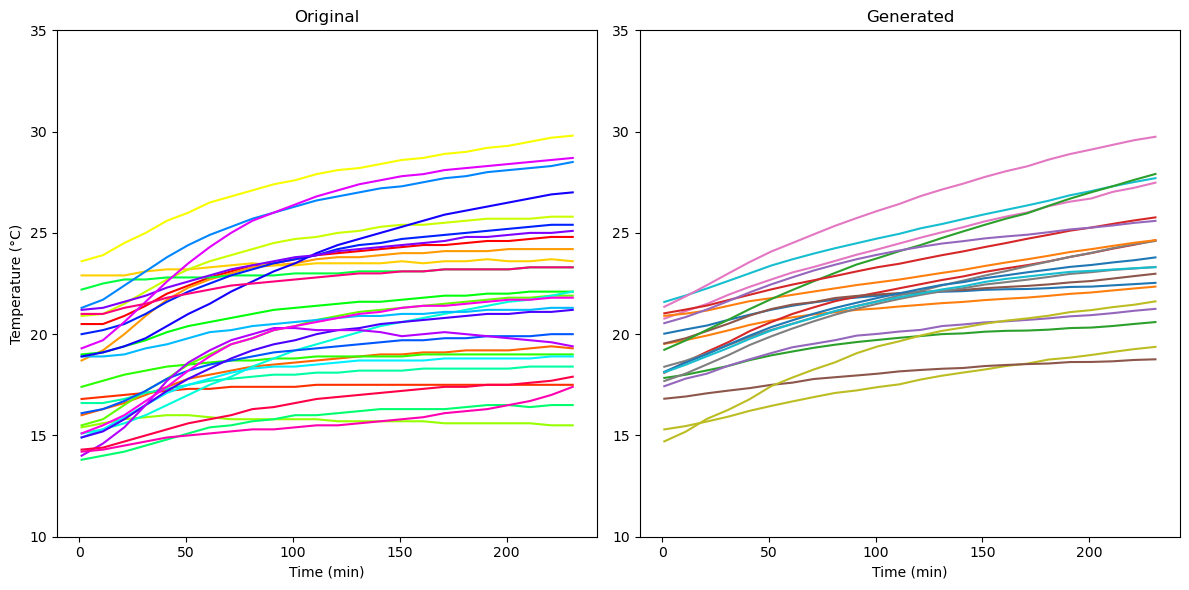

Training Progress:  64%|██████▍   | 258/400 [00:26<00:13, 10.26it/s]

Epoch 260: Train Loss = 1.2635, KL_phy = 2.4879, KL_delta = 3.2261, MSE = 0.6449, CE = 0.1462, Reg_Loss = 0.5033, Alpha = 0.8883
Validation Loss = 1.6732, Val_KL_phy = 2.4731, Val_KL_delta = 3.1699, Val_MSE = 0.9192, Val_CE = 0.1386, Val_Reg_Loss = 0.6586, Val_Alpha = 0.8879


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


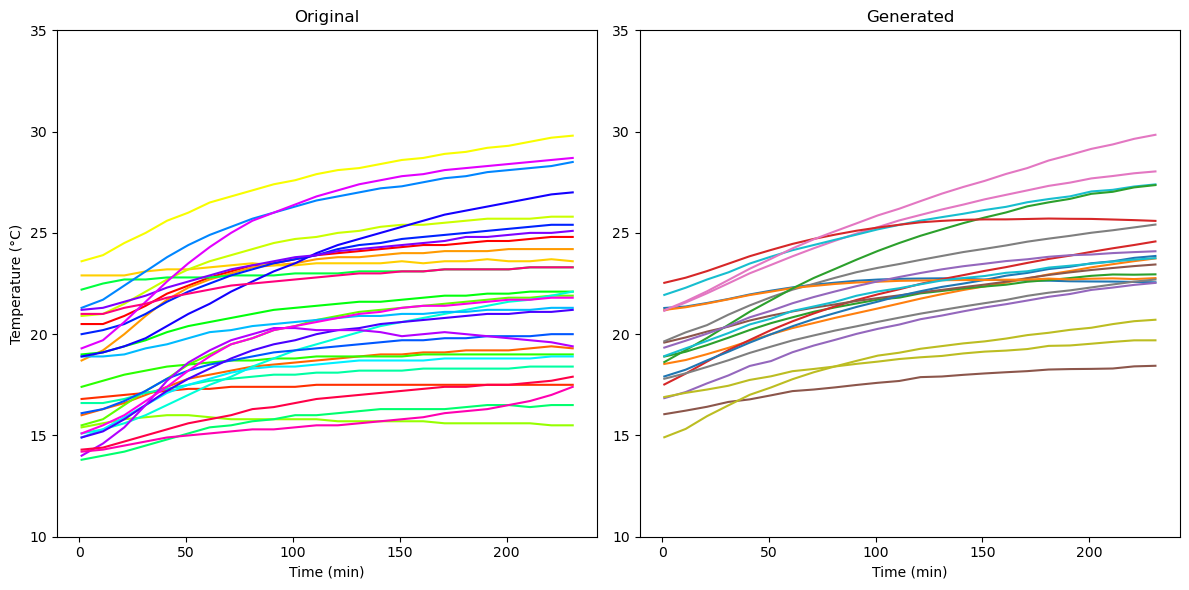

Training Progress:  70%|██████▉   | 278/400 [00:28<00:11, 10.32it/s]

Epoch 280: Train Loss = 1.1290, KL_phy = 2.4582, KL_delta = 3.0175, MSE = 0.5848, CE = 0.1369, Reg_Loss = 0.4366, Alpha = 0.8699
Validation Loss = 1.8342, Val_KL_phy = 2.4382, Val_KL_delta = 2.9732, Val_MSE = 1.0003, Val_CE = 0.1346, Val_Reg_Loss = 0.7723, Val_Alpha = 0.8696


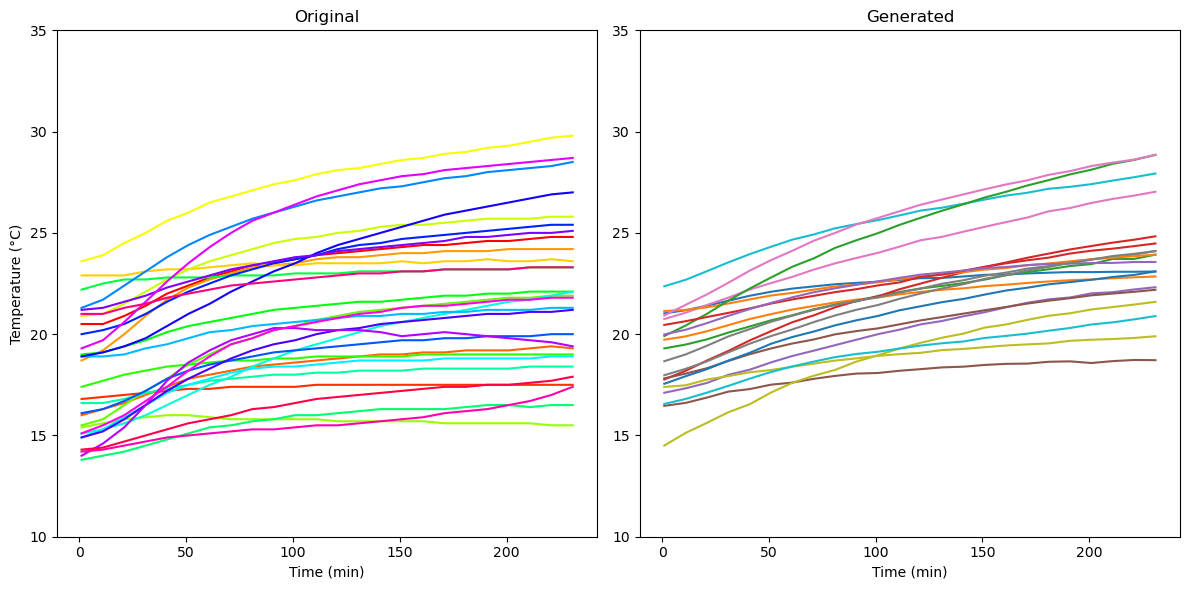

Training Progress:  74%|███████▍  | 298/400 [00:31<00:09, 10.37it/s]

Epoch 300: Train Loss = 1.2366, KL_phy = 2.4631, KL_delta = 2.8890, MSE = 0.6155, CE = 0.1348, Reg_Loss = 0.5405, Alpha = 0.8521
Validation Loss = 1.6961, Val_KL_phy = 2.4322, Val_KL_delta = 2.8107, Val_MSE = 0.8525, Val_CE = 0.1216, Val_Reg_Loss = 0.8059, Val_Alpha = 0.8517


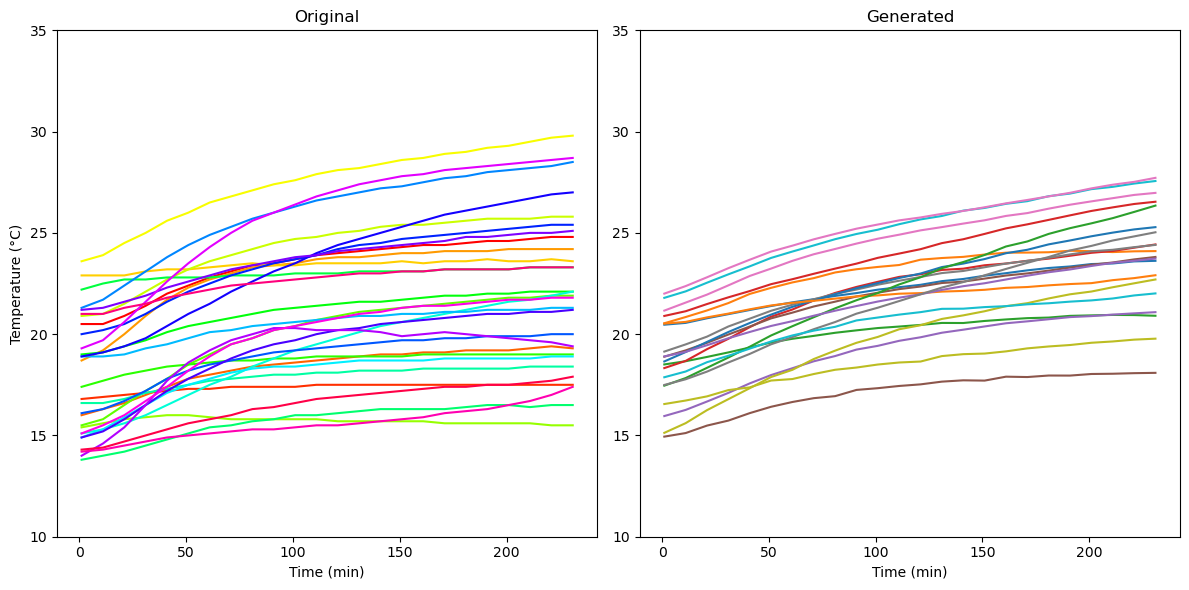

Training Progress:  80%|███████▉  | 318/400 [00:33<00:07, 10.29it/s]

Epoch 320: Train Loss = 1.2175, KL_phy = 2.5045, KL_delta = 2.7546, MSE = 0.6121, CE = 0.1323, Reg_Loss = 0.5363, Alpha = 0.8348
Validation Loss = 1.7857, Val_KL_phy = 2.4807, Val_KL_delta = 2.7180, Val_MSE = 0.9612, Val_CE = 0.1331, Val_Reg_Loss = 0.8011, Val_Alpha = 0.8344


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


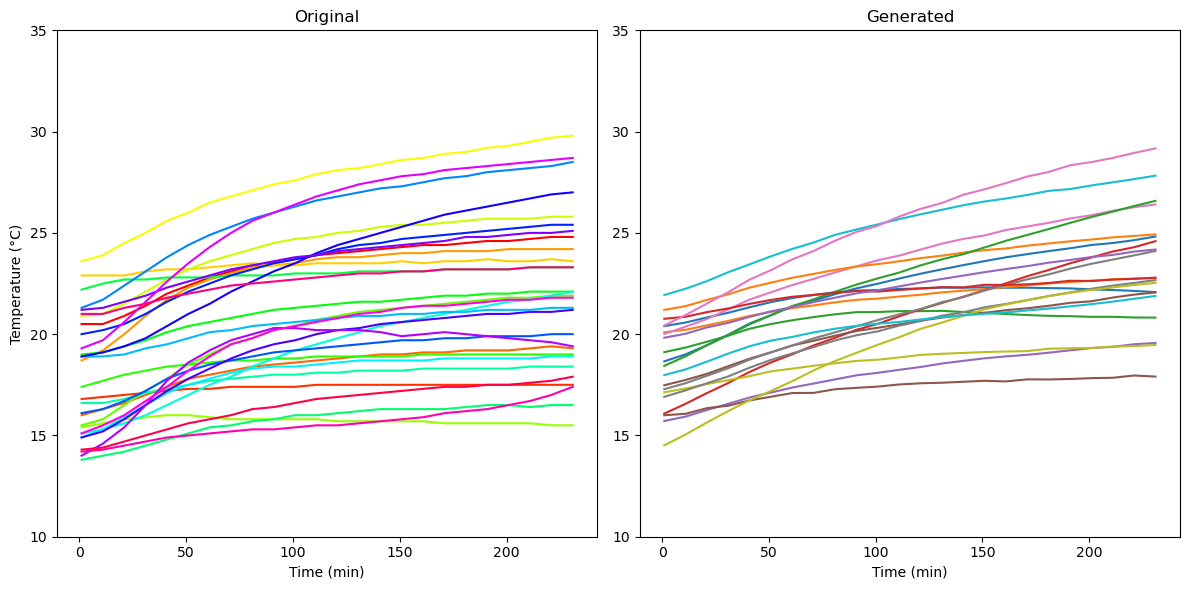

Training Progress:  84%|████████▍ | 338/400 [00:35<00:06, 10.32it/s]

Epoch 340: Train Loss = 1.2011, KL_phy = 2.4983, KL_delta = 2.6736, MSE = 0.5901, CE = 0.1364, Reg_Loss = 0.5572, Alpha = 0.8179
Validation Loss = 1.6240, Val_KL_phy = 2.4962, Val_KL_delta = 2.6316, Val_MSE = 0.8739, Val_CE = 0.1264, Val_Reg_Loss = 0.7294, Val_Alpha = 0.8175


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


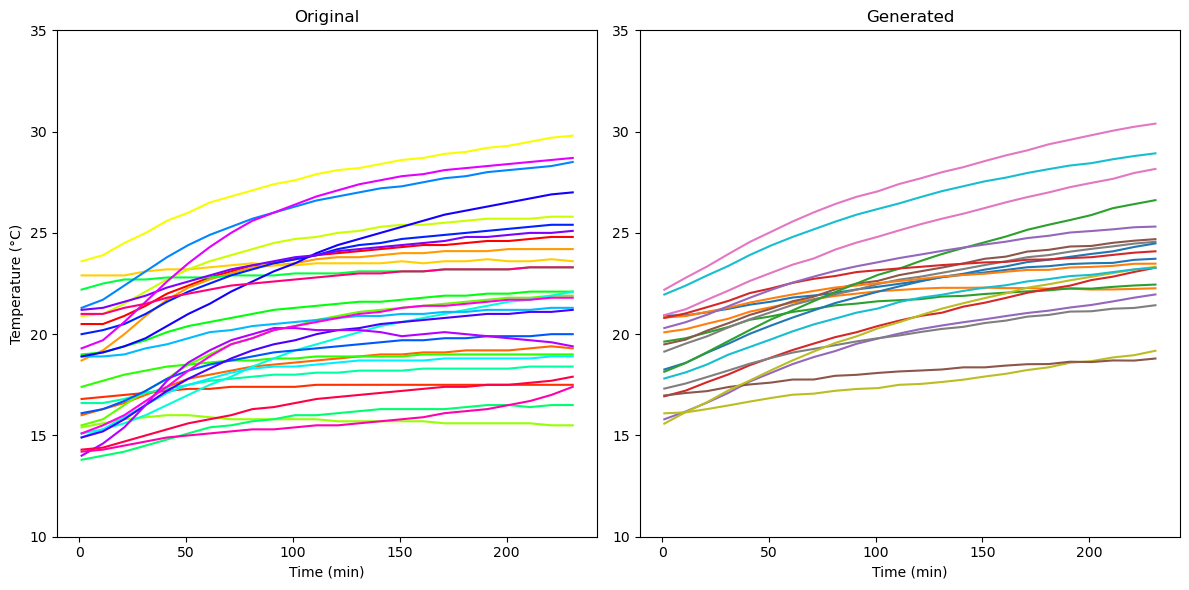

Training Progress:  90%|████████▉ | 358/400 [00:37<00:04, 10.31it/s]

Epoch 360: Train Loss = 1.2240, KL_phy = 2.5131, KL_delta = 2.6130, MSE = 0.5940, CE = 0.1338, Reg_Loss = 0.5942, Alpha = 0.8013
Validation Loss = 1.7789, Val_KL_phy = 2.4886, Val_KL_delta = 2.5605, Val_MSE = 0.9071, Val_CE = 0.1189, Val_Reg_Loss = 0.8994, Val_Alpha = 0.8009


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


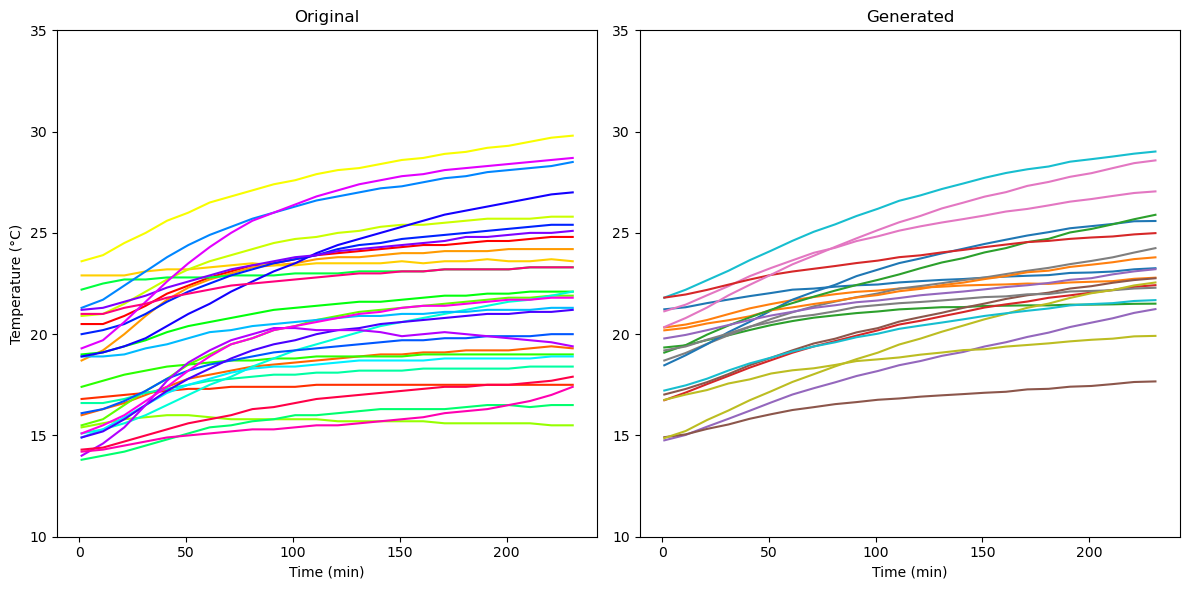

Training Progress:  94%|█████████▍| 378/400 [00:39<00:02, 10.33it/s]

Epoch 380: Train Loss = 1.1754, KL_phy = 2.5214, KL_delta = 2.5317, MSE = 0.5843, CE = 0.1379, Reg_Loss = 0.5599, Alpha = 0.7849
Validation Loss = 1.7094, Val_KL_phy = 2.4976, Val_KL_delta = 2.4811, Val_MSE = 0.8738, Val_CE = 0.1196, Val_Reg_Loss = 0.8746, Val_Alpha = 0.7846


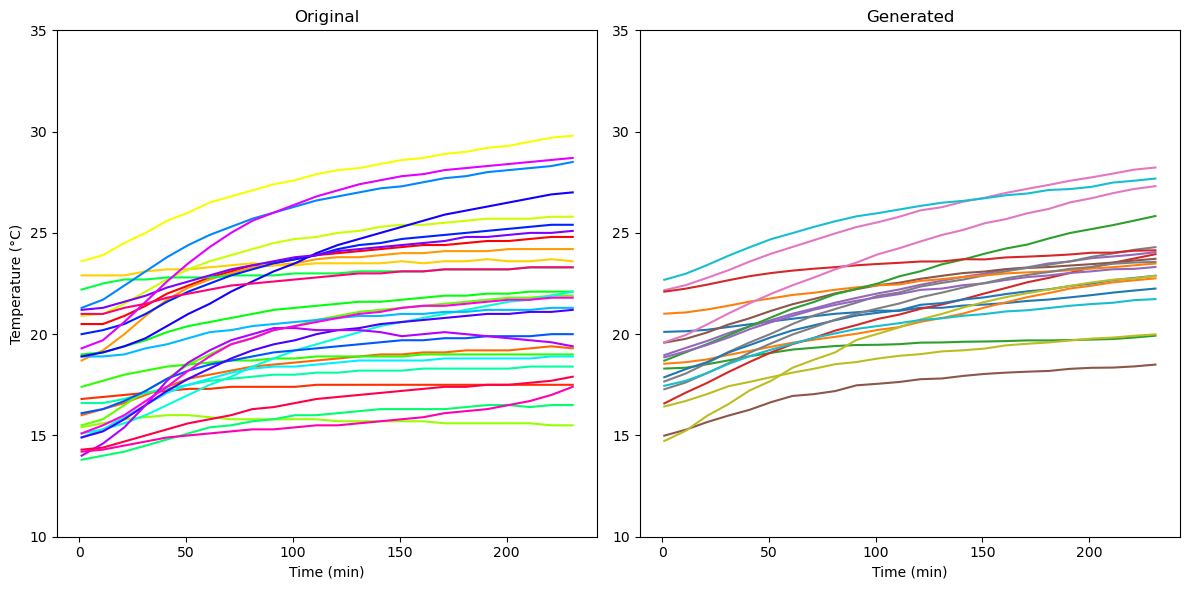

Training Progress: 100%|█████████▉| 398/400 [00:41<00:00,  9.80it/s]

Epoch 400: Train Loss = 1.2414, KL_phy = 2.5120, KL_delta = 2.4835, MSE = 0.6086, CE = 0.1328, Reg_Loss = 0.6277, Alpha = 0.7693
Validation Loss = 1.6711, Val_KL_phy = 2.5131, Val_KL_delta = 2.4148, Val_MSE = 0.8278, Val_CE = 0.1184, Val_Reg_Loss = 0.9045, Val_Alpha = 0.7689


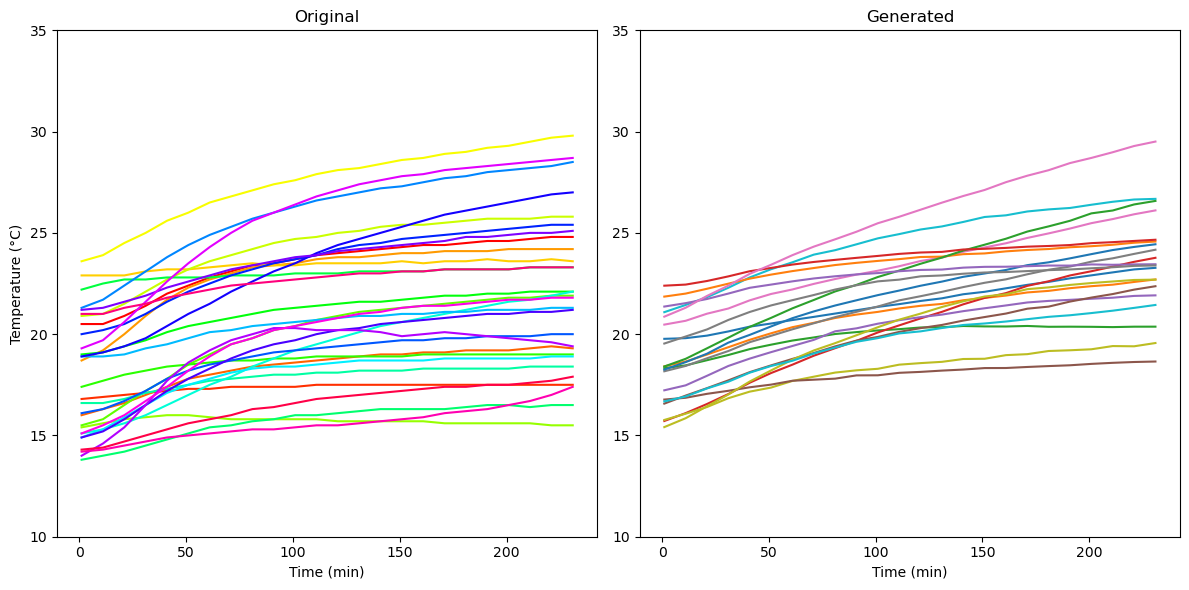

Training Progress: 100%|██████████| 400/400 [00:41<00:00,  9.57it/s]


In [12]:
num_epochs=4
epochs=range(num_epochs)

annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.03, 
                                       beta_max=0.03)
beta_annealed = annealing_strategy.get_beta_vector()

beta_delta=beta_annealed
beta_phy=beta_annealed
ns = 20
min_T, max_T = 12, 25
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)

fit_res = model.fit(train_loader=train_loader, 
                    val_loader=val_loader, 
                    opt=opt, 
                    beta_delta=beta_delta,
                    beta_phy=beta_phy,
                    num_epochs=num_epochs,
                   seed=0, plot=True, df=df_h, ns=ns, T0=T0, Ts=Ts, t_uni=t_uni/240, axs_ylim=(10, 35))


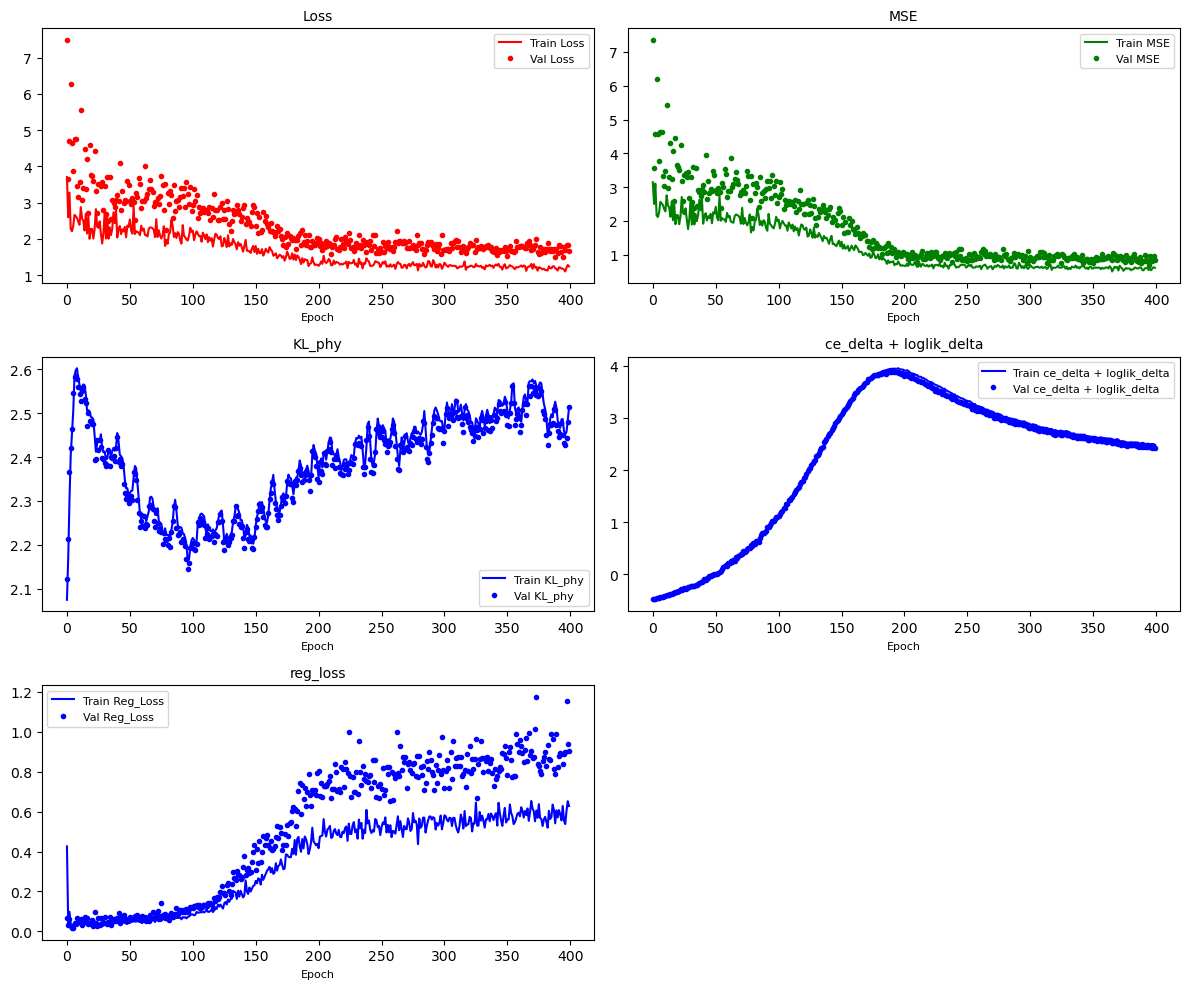

In [13]:
# Extract quantities for plotting
epochs = fit_res['epochs']
l_loss = fit_res['train_loss']
val_loss = fit_res['val_loss']
mse = fit_res['train_mse']
val_mse = fit_res['val_mse']
KL_phy = fit_res['train_KL_phy']
val_KL_phy = fit_res['val_KL_phy']
KL_delta = fit_res['train_KL_delta']
val_KL_delta = fit_res['val_KL_delta']
reg_loss = fit_res['train_reg_loss']
val_reg_loss = fit_res['val_reg_loss']

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # Keeping original figure size

# Loss plot (train vs. validation)
axs[0, 0].plot(epochs, l_loss, 'r-', label='Train Loss')
axs[0, 0].plot(epochs, val_loss, 'ro', label='Val Loss', markersize=3)  # Only points for validation
axs[0, 0].set_title('Loss', fontsize=10)
axs[0, 0].set_xlabel('Epoch', fontsize=8)
axs[0, 0].legend(fontsize=8)

# MSE plot (train vs. validation)
axs[0, 1].plot(epochs, mse, 'g-', label='Train MSE')
axs[0, 1].plot(epochs, val_mse, 'go', label='Val MSE', markersize=3)  # Only points for validation
axs[0, 1].set_title('MSE', fontsize=10)
axs[0, 1].set_xlabel('Epoch', fontsize=8)
axs[0, 1].legend(fontsize=8)

# KL Divergence (train vs. validation)
axs[1, 0].plot(epochs, KL_phy, 'b-', label='Train KL_phy')
axs[1, 0].plot(epochs, val_KL_phy, 'bo', label='Val KL_phy', markersize=3)  # Only points for validation
axs[1, 0].set_title('KL_phy', fontsize=10)
axs[1, 0].set_xlabel('Epoch', fontsize=8)
axs[1, 0].legend(fontsize=8)

# KL_delta + loglik_delta (train vs. validation)
axs[1, 1].plot(epochs, KL_delta, 'b-', label='Train ce_delta + loglik_delta')
axs[1, 1].plot(epochs, val_KL_delta, 'bo', label='Val ce_delta + loglik_delta', markersize=3)  # Only points for validation
axs[1, 1].set_title('ce_delta + loglik_delta', fontsize=10)
axs[1, 1].set_xlabel('Epoch', fontsize=8)
axs[1, 1].legend(fontsize=8)

# Regularization loss (train vs. validation) - Spanning entire third row
axs[2, 0].plot(epochs, reg_loss, 'b-', label='Train Reg_Loss')
axs[2, 0].plot(epochs, val_reg_loss, 'bo', label='Val Reg_Loss', markersize=3)  # Only points for validation
axs[2, 0].set_title('reg_loss', fontsize=10)
axs[2, 0].set_xlabel('Epoch', fontsize=8)
axs[2, 0].legend(fontsize=8)

# Remove empty subplot (since we have 5 plots, and this grid would have 6 subplots)
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

In [14]:
q_mu_delta_l, q_var_delta_l, q_mu_phy_l, q_var_phy_l, x_hat_l, x_hat_phy_l, x_hat_delta_l, = [], [], [], [], [], [], []
batches_data = []
# Iterate through the train_loader to obtain x_batch
for x_batch in train_loader:
    with torch.no_grad():
        x_batch = x_batch.squeeze(0)  

        x_hat_i, x_hat_phy_i, x_hat_delta_i, _, _, _, q_mu_delta_i, q_var_delta_i, q_mu_phy_i, q_var_phy_i = model(x_batch)

        q_mu_delta_l.append(q_mu_delta_i)
        q_var_delta_l.append(q_var_delta_i)
        q_mu_phy_l.append(q_mu_phy_i)
        q_var_phy_l.append(q_var_phy_i)
        x_hat_l.append(x_hat_i)
        x_hat_phy_l.append(x_hat_phy_i)
        x_hat_delta_l.append(x_hat_delta_i)
        batches_data.append(x_batch)
        
mean_q_mu_phy = sum(q_mu_phy_l) / len(q_mu_phy_l)
mean_q_var_phy = sum(q_var_phy_l) / len(q_var_phy_l)
mu_s = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)


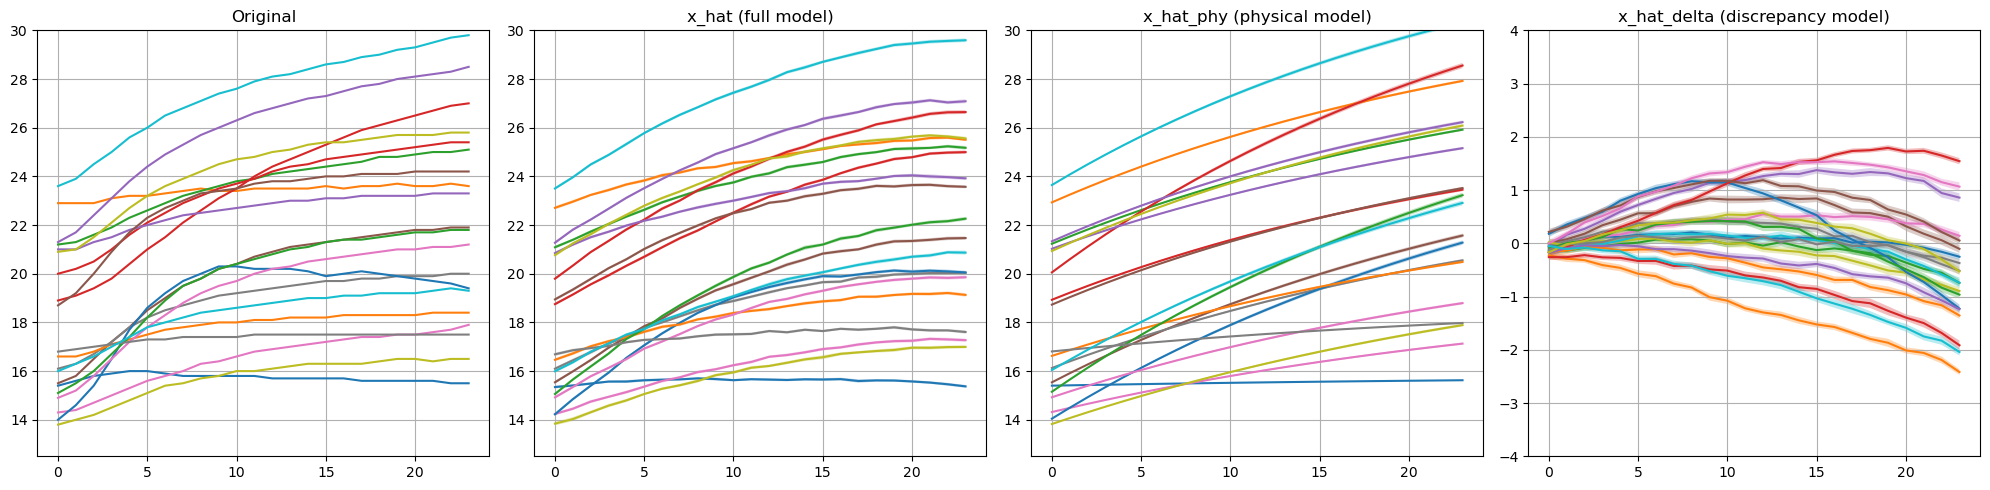

In [15]:
x_hat_numpy = [x_hat_l[sa].numpy() for sa in range(len(x_hat_l))]
batches_data_numpy = [batches_data[sa][:, 0].unsqueeze(1).numpy() for sa in range(len(batches_data))]
x_hat_phy_numpy = [x_hat_phy_l[sa].numpy() for sa in range(len(x_hat_phy_l))]
x_hat_delta_numpy = [x_hat_delta_l[sa].numpy() for sa in range(len(x_hat_delta_l))]

# Number of subplots is the length of the lists (assuming all have the same length)
num_plots = len(x_hat_numpy)

# Function to compute mean and 95% CI
def compute_mean_and_ci(samples):
    samples = np.array(samples)  # Ensure it's a NumPy array
    mean = np.mean(samples, axis=0)  # Mean across samples
    std = np.std(samples, axis=0)   # Standard deviation
    ci = 1.96 * (std / np.sqrt(samples.shape[0]))  # 95% CI using SEM
    return mean, mean - ci, mean + ci

# Initialize lists to store multiple samples
x_hat_samples, x_hat_phy_samples, x_hat_delta_samples = [], [], []

# Number of samples to generate for each quantity
num_samples = 50

# List to store the original data
# batches_data_numpy = []

# Iterate through the train_loader to obtain x_batch
for x_batch in train_loader:
    x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary
    x_hat_batch, x_hat_phy_batch, x_hat_delta_batch = [], [], []
    
    # Add original data
   # batches_data_numpy.append(x_batch.numpy().flatten())

    for _ in range(num_samples):
        with torch.no_grad():
            x_hat_i, x_hat_phy_i, x_hat_delta_i, _, _, _, q_mu_delta_i, q_var_delta_i, q_mu_phy_i, q_var_phy_i = model(x_batch)
            x_hat_batch.append(x_hat_i.numpy().flatten())  # Flatten to 1D
            x_hat_phy_batch.append(x_hat_phy_i.numpy().flatten())
            x_hat_delta_batch.append(x_hat_delta_i.numpy().flatten())
    
    # Store all samples for the batch
    x_hat_samples.append(np.stack(x_hat_batch))  # Shape: [num_samples, seq_len]
    x_hat_phy_samples.append(np.stack(x_hat_phy_batch))
    x_hat_delta_samples.append(np.stack(x_hat_delta_batch))

# Plot results with four subplots: real data, full model, physical model, discrepancy model
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot Real Data (outside the loop)
for i in range(num_plots):
    # First subplot
    axs[0].plot(batches_data_numpy[i], label=f'batches_data[{i}]')
    axs[0].set_title('Original')
    axs[0].set_ylim(12.5, 30)

# Plot reconstructed quantities for each batch
for i, (x_hat, x_hat_phy, x_hat_delta) in enumerate(zip(x_hat_samples, x_hat_phy_samples, x_hat_delta_samples)):
    # Compute mean and CI for each quantity
    mean_x_hat, lower_x_hat, upper_x_hat = compute_mean_and_ci(x_hat)
    mean_x_hat_phy, lower_x_hat_phy, upper_x_hat_phy = compute_mean_and_ci(x_hat_phy)
    mean_x_hat_delta, lower_x_hat_delta, upper_x_hat_delta = compute_mean_and_ci(x_hat_delta)

    # Plot Full Model
    axs[1].plot(mean_x_hat, label=f'Batch {i} Mean')
    axs[1].fill_between(range(len(mean_x_hat)), lower_x_hat, upper_x_hat, alpha=0.3, label=f'Batch {i} CI')
    axs[1].set_title('x_hat (full model)')
    axs[1].set_ylim(12.5, 30)

    # Plot Physical Model
    axs[2].plot(mean_x_hat_phy, label=f'Batch {i} Mean')
    axs[2].fill_between(range(len(mean_x_hat_phy)), lower_x_hat_phy, upper_x_hat_phy, alpha=0.3, label=f'Batch {i} CI')
    axs[2].set_title('x_hat_phy (physical model)')
    axs[2].set_ylim(12.5, 30)

    # Plot Discrepancy Model
    axs[3].plot(mean_x_hat_delta, label=f'Batch {i} Mean')
    axs[3].fill_between(range(len(mean_x_hat_delta)), lower_x_hat_delta, upper_x_hat_delta, alpha=0.3, label=f'Batch {i} CI')
    axs[3].set_title('x_hat_delta (discrepancy model)')
    axs[3].set_ylim(-4, 4)

# Add legends to reconstructed plots
for ax in axs[0:]:
    #ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


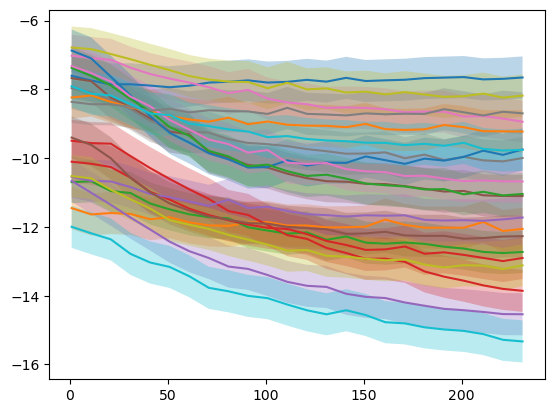

In [16]:
for l in range(len(q_mu_delta_l)):
    with torch.no_grad():
        z_mu, z_var = model.GP.cond_mu_cov(t_uni, t_uni, q_mu_delta_l[l], q_var_delta_l[l].squeeze())
        plt.plot(t_uni,z_mu)
        plt.fill_between(t_uni, y1=z_mu.squeeze()+1.96*z_var.diag().sqrt(), y2=z_mu.squeeze()-1.96*z_var.diag().sqrt(),alpha=0.3, label='1.96*std')
plt.show()  #

In [17]:
mu_s = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)

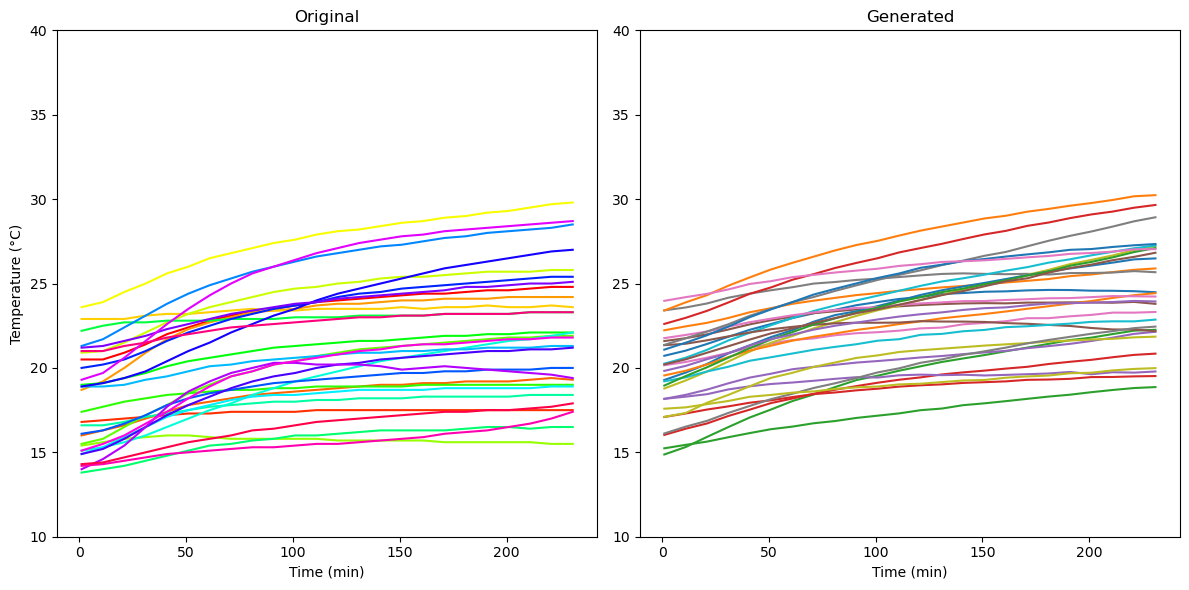

0.0717130471020937

In [18]:
ns = total_size
min_T, max_T = 13, 30
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, generated_data, fig, axs=model.generate_and_plot(mu_s, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_h,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(10, 40),
                        plot=True,
                        seed=0
                       )
# Ts,T0,k_values
mmd_metric = tsgm.metrics.MMDMetric()
Gd = torch.stack(generated_data)
full_data = DataLoader(dataset)
original_data_list = []

# Iterate through the DataLoader
for batch in full_data:
    original_data_list.append(batch[0][:,0])

# Stack to create a tensor of shape [total_samples, 24, 1]
original_data = torch.stack(original_data_list)
original_data = original_data.unsqueeze(-1)
# Check the shape
# print(original_data.shape)
mmd_metric(original_data, Gd)

In [19]:
num_datasets = 100
mmd_PIGPVAE_values = []
min_T, max_T = 13, 30
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
for i in range(num_datasets):

    # Generate synthetic data
    k_values, gd_l_PIGPVAE, fig, axs = model.generate_and_plot(
        mu_s,
        mean_q_mu_phy,
        mean_q_var_phy,
        df=df_h,
        num_unique_intervals=num_unique_intervals,
        ns=ns,
        T0=T0,
        Ts=Ts,
        t_uni=t_uni / 240,
        axs_ylim=(0, 35),
        plot=False,
        seed=i
    )
    
    # Stack generated data and compute MMD
    Gd_PIGPVAE = torch.stack(gd_l_PIGPVAE)
    mmd_value = mmd_metric(original_data, Gd_PIGPVAE)
    
    # Append MMD value
    mmd_PIGPVAE_values.append(mmd_value)

# Convert list to tensor
mmd_PIGPVAE_tensor = torch.tensor(mmd_PIGPVAE_values)

# Print or save results
# print(mmd_PIGPVAE_tensor)
mmd_PIGPVAE_tensor.min(), mmd_PIGPVAE_tensor.max(), mmd_PIGPVAE_tensor.mean(), mmd_PIGPVAE_tensor.std()

(tensor(0.0609, dtype=torch.float64),
 tensor(0.0794, dtype=torch.float64),
 tensor(0.0708, dtype=torch.float64),
 tensor(0.0036, dtype=torch.float64))

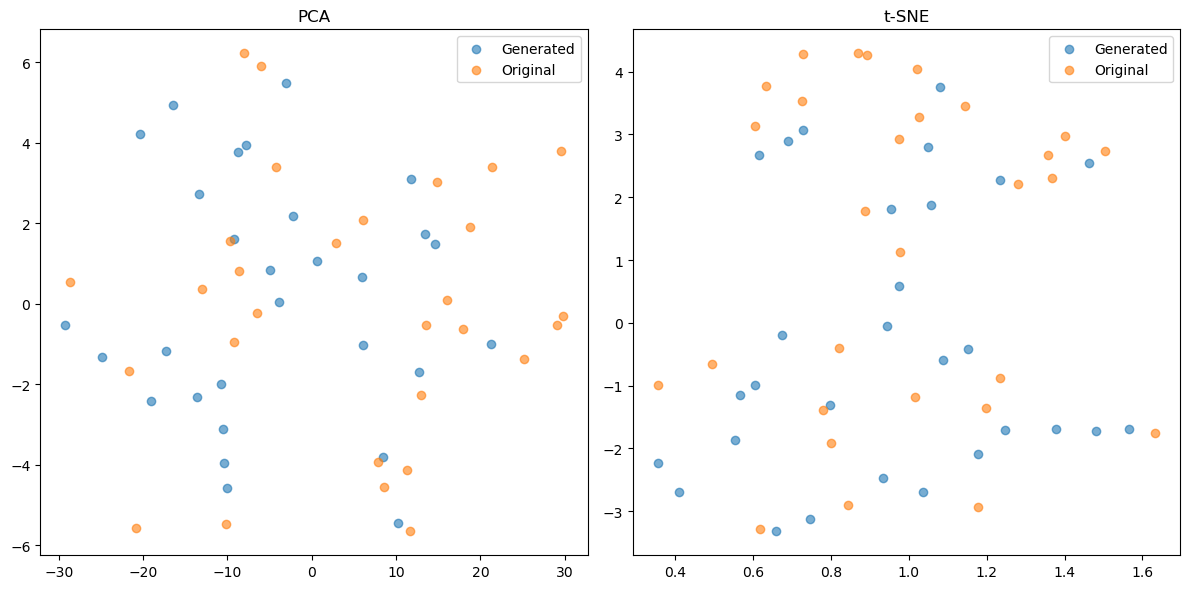

In [20]:

# Assume Gd and original_data are your generated and original data

# Reshape data to 2D format (num_samples, num_features)
Gd_reshaped = Gd.view(Gd.size(0), -1).numpy()
original_data_reshaped = original_data.view(original_data.size(0), -1).numpy()

# Concatenate generated and original data for visualization
data_combined = np.concatenate([Gd_reshaped, original_data_reshaped], axis=0)
labels = np.array(['Generated'] * Gd.size(0) + ['Original'] * original_data.size(0))

# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_combined)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for label in np.unique(labels):
    plt.scatter(pca_result[labels == label, 0], pca_result[labels == label, 1], label=label, alpha=0.6)
plt.title("PCA")

plt.legend()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_combined)

plt.subplot(1, 2, 2)
for label in np.unique(labels):
    plt.scatter(tsne_result[labels == label, 0], tsne_result[labels == label, 1], label=label, alpha=0.6)
plt.title("t-SNE")

plt.legend()

plt.tight_layout()
plt.show()

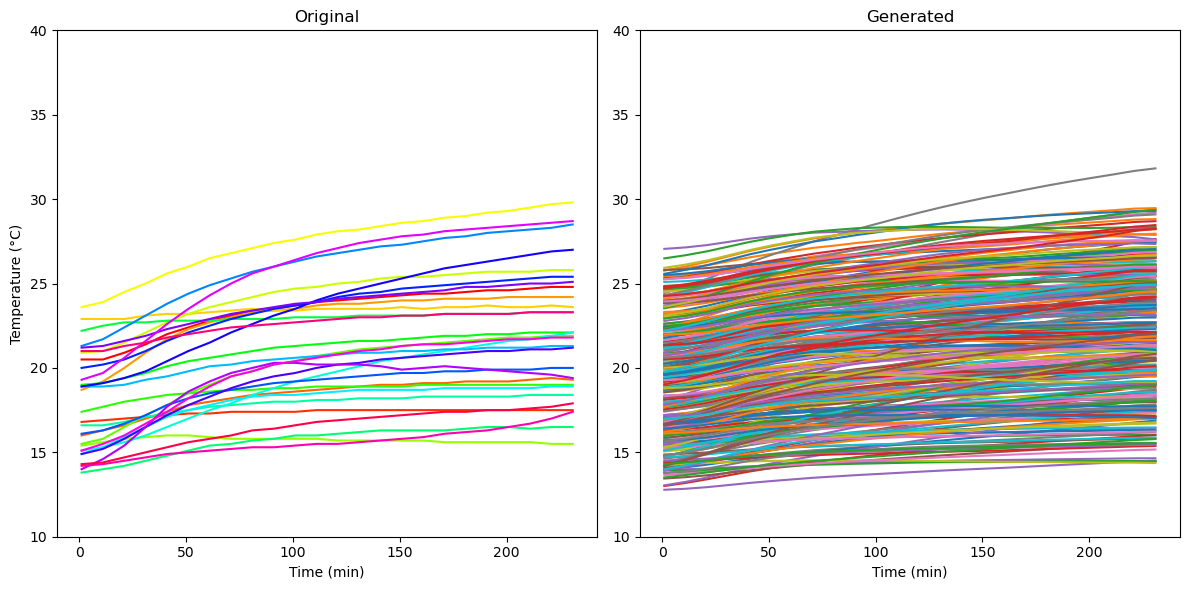

In [21]:
ns = 300
min_T, max_T = 11, 32
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, generated_data, fig, axs=model.generate_and_plot2(mu_s, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_h,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(10, 40),
                        plot=True,
                        seed=0
                       )

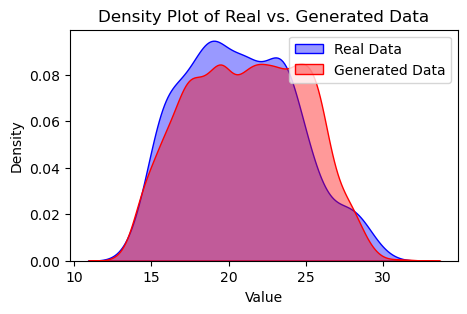

In [22]:
# Flatten the real and generated data to be one-dimensional
original_data_flattened = original_data.view(-1).numpy()
Gd = torch.stack(generated_data)
generated_data_flattened = Gd.view(-1).numpy()

# Plot overlapping density plots
plt.figure(figsize=(5, 3))
sns.kdeplot(original_data_flattened, label="Real Data", color="blue", fill=True, alpha=0.4)
sns.kdeplot(generated_data_flattened, label="Generated Data", color="red", fill=True, alpha=0.4)

# Customize plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Real vs. Generated Data')
plt.legend()
plt.show()


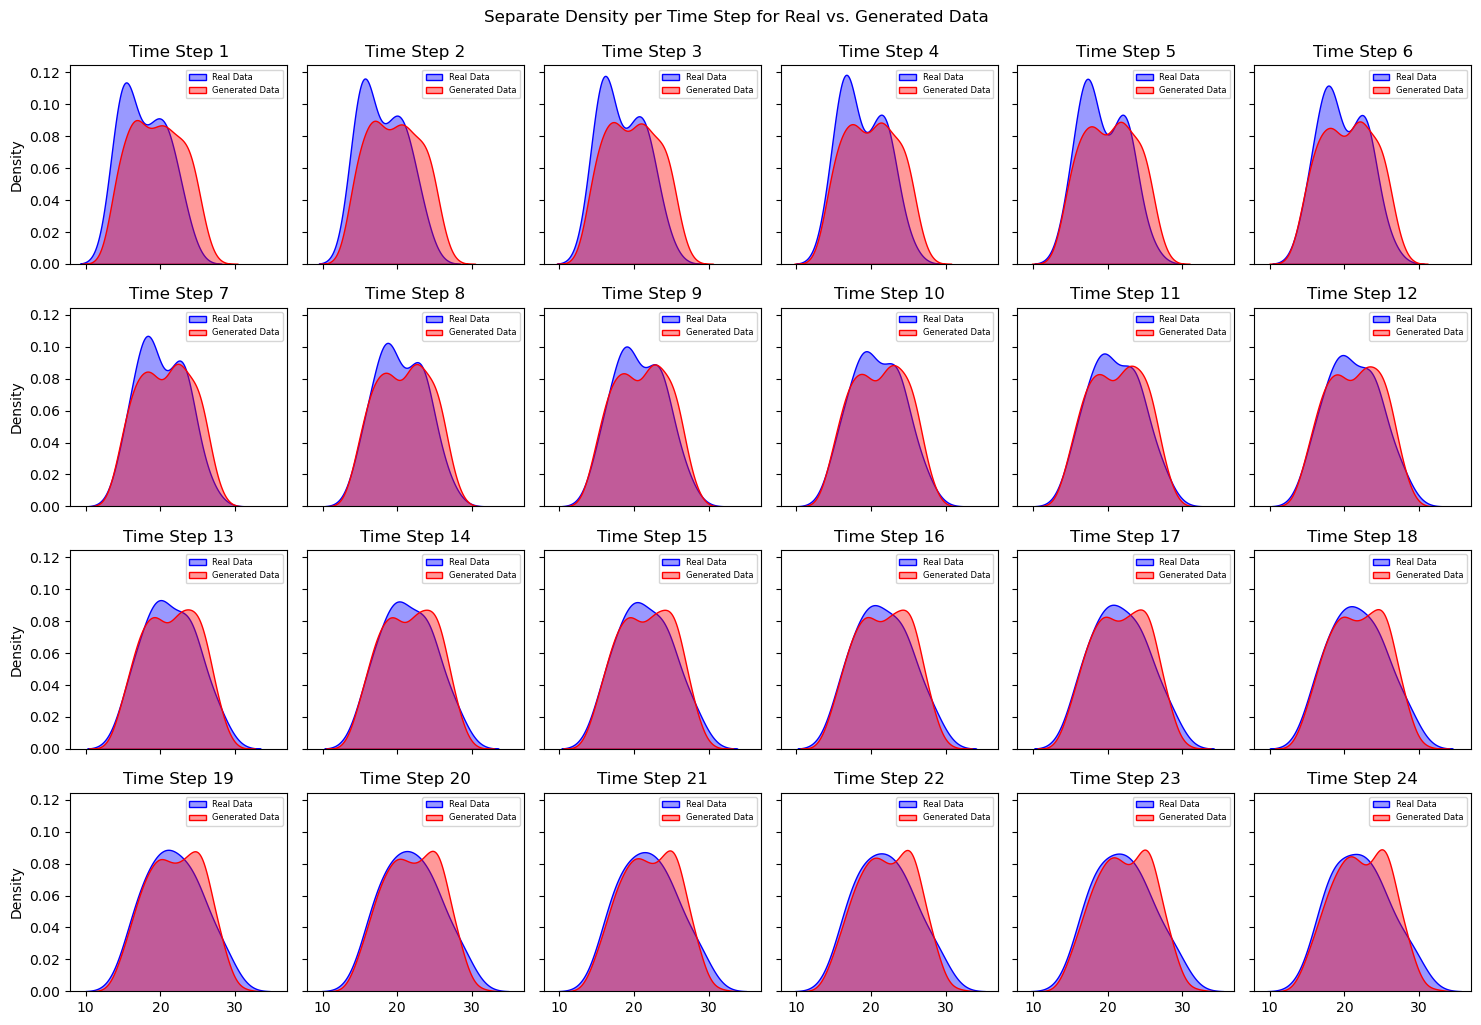

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for real and generated samples
original_data_windowed = original_data.view(total_size, 24).numpy()  # shape (28, 24)
generated_data_windowed = Gd.view(ns, 24).numpy()  # shape (ns, 24)

# Set up the number of subplots (one for each time step)
num_time_steps = 24
fig, axes = plt.subplots(4, 6, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each time step and plot density
for t in range(num_time_steps):
    # Extract the values at time step `t` for real and generated data
    real_values_at_t = original_data_windowed[:, t]
    generated_values_at_t = generated_data_windowed[:, t]
    
    # Plot density for real and generated data at each time step
    sns.kdeplot(real_values_at_t, ax=axes[t], label="Real Data", color="blue", fill=True, alpha=0.4)
    sns.kdeplot(generated_values_at_t, ax=axes[t], label="Generated Data", color="red", fill=True, alpha=0.4)
    
    # Label each subplot
    axes[t].set_title(f'Time Step {t + 1}')
    axes[t].legend(loc='upper right', fontsize=6)

# Adjust layout and add global labels
plt.tight_layout()
fig.suptitle('Separate Density per Time Step for Real vs. Generated Data', y=1.02)
plt.show()


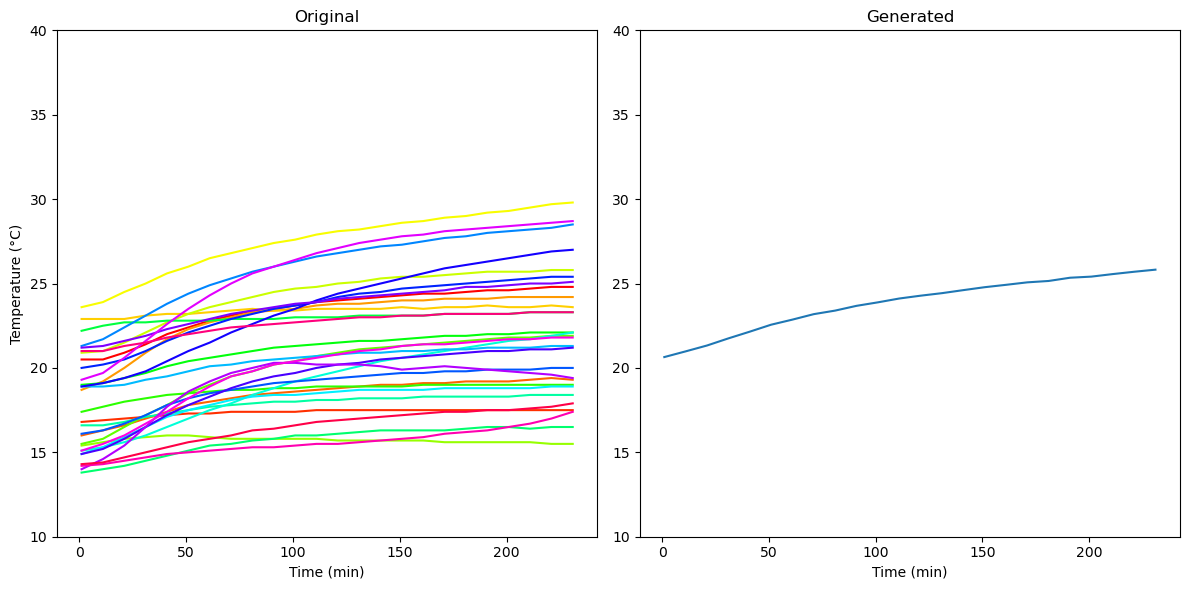

tensor([24.0049]) tensor([35.2612]) [0.7719494104385376]


In [24]:
ns = 1
min_T, max_T = 10, 25
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, generated_data, fig, axs=model.generate_and_plot(mu_s, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_h,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(10, 40),
                        plot=True
                       )
print(T0,Ts,k_values)


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


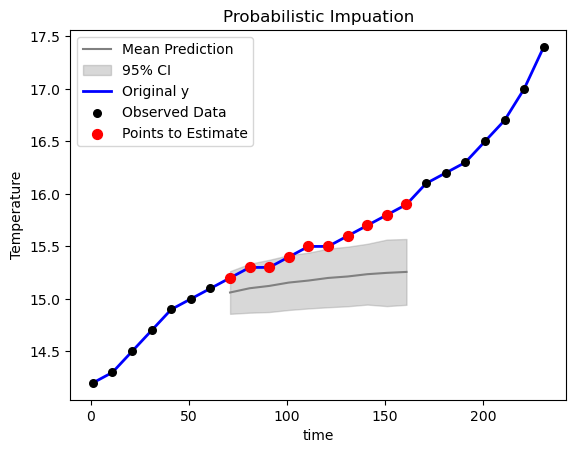

In [25]:
# Set number of samples
num_samples = 1000
dec_delta_values = []

# Load batch data and select the y values
for i, batch in enumerate(val_loader):
    if i == 2:  
        y = batch[0, :, 0]
        break

X = t_uni / 240  # Define X and normalize

# Calculate middle index and select 5 middle points to remove
num_points_to_remove = 10
mid_index = len(X) // 2  # Middle index
start_index = mid_index - num_points_to_remove // 2
indices_to_remove = torch.arange(start_index, start_index + num_points_to_remove)

# Extract points to estimate and remove them from X, y, and batch
X_to_estimate = X[indices_to_remove]
y_to_estimate = y[indices_to_remove]
batch_to_estimate = batch[:, indices_to_remove, :]
batch_to_estimate = batch_to_estimate.squeeze()
T, Ts, t = batch_to_estimate[:, 0].unsqueeze(1), batch_to_estimate[:, 1].mean(), batch_to_estimate[:, 2]
T0 = T[0]
# Create a mask for filtering
mask = torch.ones(len(X), dtype=bool)
mask[indices_to_remove] = False

# Filter out the selected points from X, y, and batch
X_filtered = X[mask]
y_filtered = y[mask]
batch_filtered = batch[:, mask, :]
batch_filtered = batch_filtered.squeeze()
T_obs, Ts_obs, t_obs = batch_filtered[:, 0].unsqueeze(1), batch_filtered[:, 1].mean(), batch_filtered[:, 2]

# Set X_c to the missing middle points
X_c = X_to_estimate.unsqueeze(-1)

# Model evaluation with filtered batch
with torch.no_grad():
    
    _, _, _, q_mu_delta, q_var_delta, _, _, _, _ = model.encode(T_obs, t_obs)
    _, _, _, _, _, q_mu_phy, q_var_phy, _, _ = model.encode(T, t)
    mu_p, cov_p = model.GP.cond_mu_cov(X_filtered, X_c, q_mu_delta, q_var_delta)
    # Loop to generate multiple `z` samples for interpolation
    for i in range(num_samples):
        # Reparameterize to get z
        k = model.reparameterization(q_mu_phy, q_var_phy)
        # k = torch.clamp(k, min=0, max=10)
        x_hat_phy = model.decode_phy(T0, t, Ts, k.mean())
        T0_broadcasted = torch.full_like(x_hat_phy, T0.item())
        Ts_broadcasted = torch.full_like(x_hat_phy, Ts.item())
        z_delta = model.reparameterization(mu_p, cov_p.diag())
        X_delta = torch.cat((x_hat_phy.unsqueeze(1), z_delta.unsqueeze(1), k, T0_broadcasted.unsqueeze(1), Ts_broadcasted.unsqueeze(1)), dim=1)
        # z_delta = z_delta.unsqueeze(1)
        dec_delta = model.decode_delta(X_delta)
        dec_phy = model.decode_phy(T0, t, Ts, k.mean())
        dec_delta_values.append(dec_phy.unsqueeze(1)+dec_delta)

# Convert stored dec values to a tensor for easy manipulation
dec_delta_values = torch.stack(dec_delta_values)  # Shape: (num_samples, num_points, 1)

# Calculate the mean and 95% confidence intervals
mean_dec = dec_delta_values.mean(dim=0).squeeze()  # Mean along the sample dimension
std_dec = dec_delta_values.std(dim=0).squeeze()    # Standard deviation along the sample dimension
ci_lower = mean_dec - 1.96 * std_dec         # Lower bound of 95% CI
ci_upper = mean_dec + 1.96 * std_dec         # Upper bound of 95% CI

# Plot the mean and 95% confidence intervals as shaded areas
plt.plot(X_c.numpy() * 240, mean_dec.numpy(), color="grey", label="Mean Prediction")
plt.fill_between(X_c.numpy().squeeze() * 240, ci_lower.numpy(), ci_upper.numpy(), color="grey", alpha=0.3, label="95% CI")

# Plot the original data, observed data points, and missing points for estimation
plt.plot(X.numpy() * 240, y.numpy(), label="Original y", color="blue", linewidth=2)
plt.scatter(X_filtered.numpy() * 240, y_filtered.numpy(), color="black", s=30, label="Observed Data", zorder=2)  # Black dots for observed data
plt.scatter(X_to_estimate.numpy() * 240, y_to_estimate.numpy(), color="red", s=50, label="Points to Estimate", zorder=3)  # Red dots for missing points

plt.xlabel("time")
plt.ylabel("Temperature")
plt.title("Probabilistic Impuation")
plt.legend()
plt.show()


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/michailspitieris/anac

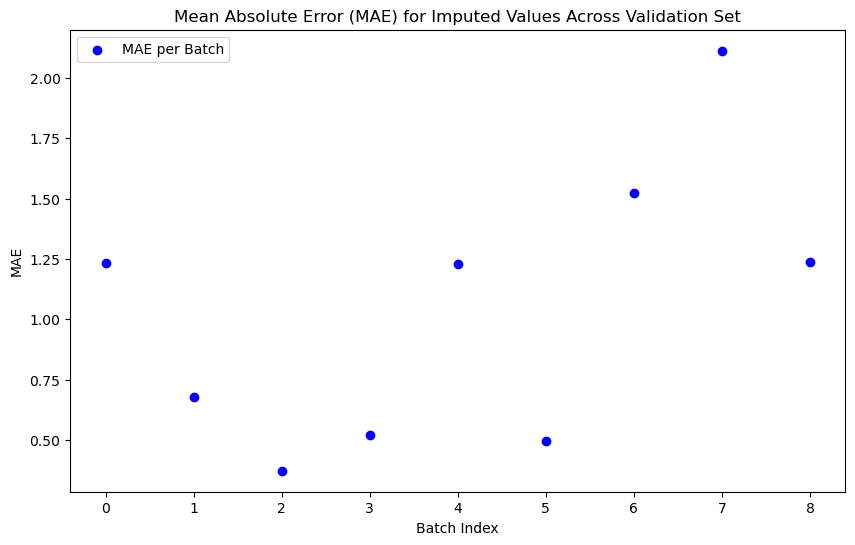

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set number of samples
num_samples = 1000
all_mae_values = []

# Loop over all batches in val_loader
for batch in val_loader:
    dec_delta_values = []
    
    # Select the y values for the current batch
    y = batch[0, :, 0]

    X = t_uni / 240  # Define X and normalize

    # Calculate middle index and select 5 middle points to remove
    num_points_to_remove = 10
    mid_index = len(X) // 2  # Middle index
    start_index = mid_index - num_points_to_remove // 2
    indices_to_remove = torch.arange(start_index, start_index + num_points_to_remove)

    # Extract points to estimate and remove them from X, y, and batch
    X_to_estimate = X[indices_to_remove]
    y_to_estimate = y[indices_to_remove]
    batch_to_estimate = batch[:, indices_to_remove, :]
    batch_to_estimate = batch_to_estimate.squeeze()
    T, Ts, t = batch_to_estimate[:, 0].unsqueeze(1), batch_to_estimate[:, 1].mean(), batch_to_estimate[:, 2]
    T0 = T[0]

    # Create a mask for filtering
    mask = torch.ones(len(X), dtype=bool)
    mask[indices_to_remove] = False

    # Filter out the selected points from X, y, and batch
    X_filtered = X[mask]
    y_filtered = y[mask]
    batch_filtered = batch[:, mask, :]
    batch_filtered = batch_filtered.squeeze()
    T_obs, Ts_obs, t_obs = batch_filtered[:, 0].unsqueeze(1), batch_filtered[:, 1].mean(), batch_filtered[:, 2]

    # Set X_c to the missing middle points
    X_c = X_to_estimate.unsqueeze(-1)

    # Model evaluation with filtered batch
    with torch.no_grad():
        _, _, _, q_mu_delta, q_var_delta, _, _, _, _ = model.encode(T_obs, t_obs)
        _, _, _, _, _, q_mu_phy, q_var_phy, _, _ = model.encode(T, t)
        mu_p, cov_p = model.GP.cond_mu_cov(X_filtered, X_c, q_mu_delta, q_var_delta)
        
        # Generate multiple z samples for interpolation
        for _ in range(num_samples):
            # Reparameterize to get z
            k = model.reparameterization(q_mu_phy, q_var_phy)
            # k = torch.clamp(k, min=0, max=10)
            x_hat_phy = model.decode_phy(T0, t, Ts, k.mean())
            T0_broadcasted = torch.full_like(x_hat_phy, T0.item())
            Ts_broadcasted = torch.full_like(x_hat_phy, Ts.item())
            z_delta = model.reparameterization(mu_p, cov_p.diag())
            X_delta = torch.cat((x_hat_phy.unsqueeze(1), z_delta.unsqueeze(1), k, T0_broadcasted.unsqueeze(1), Ts_broadcasted.unsqueeze(1)), dim=1)
            dec_delta = model.decode_delta(X_delta)
            dec_phy = model.decode_phy(T0, t, Ts, k.mean())
            dec_delta_values.append(dec_phy.unsqueeze(1) + dec_delta)

        # Convert stored dec values to a tensor for easy manipulation
        dec_delta_values = torch.stack(dec_delta_values)  # Shape: (num_samples, num_points, 1)

        # Calculate the mean prediction for imputed values
        mean_dec = dec_delta_values.mean(dim=0).squeeze()

        # Calculate MAE for this batch
        mae = torch.mean(torch.abs(mean_dec - y_to_estimate))
        all_mae_values.append(mae.item())  # Store MAE for each batch

# Compute the overall MAE across all batches in val_loader
plt.figure(figsize=(10, 6))
plt.scatter(range(len(all_mae_values)), all_mae_values, color="blue", label="MAE per Batch")
# plt.axhline(y=overall_mae, color="red", linestyle="--", label=f"Overall MAE: {overall_mae:.4f}")
plt.xlabel("Batch Index")
plt.ylabel("MAE")
plt.title("Mean Absolute Error (MAE) for Imputed Values Across Validation Set")
plt.legend()
plt.show()

# Optional: Print the overall MAE
# print("Overall MAE for imputed values:", overall_mae)


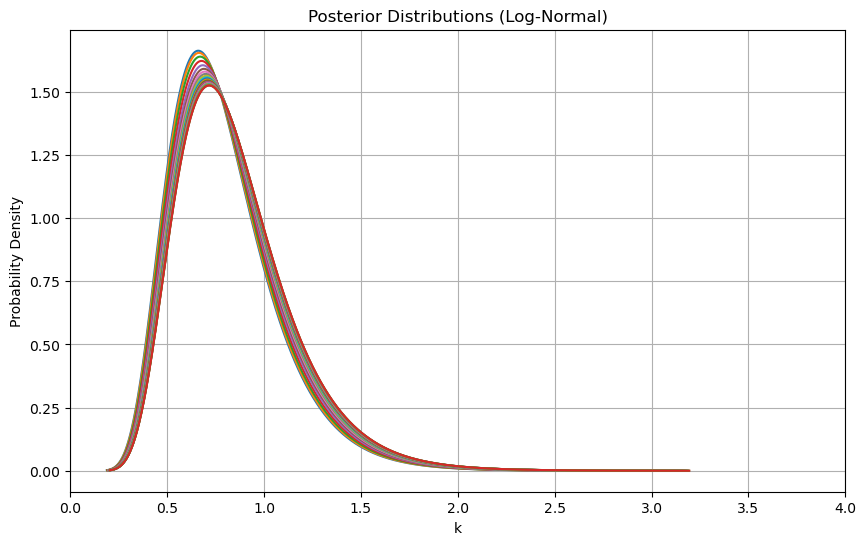

In [27]:
from scipy.stats import lognorm
import numpy as np
import matplotlib.pyplot as plt

# Assuming mean_q_mu_phy and mean_q_var_phy are PyTorch tensors
# Convert tensors to NumPy arrays or scalars
mean_q_mu_phy = [float(mu) for mu in mean_q_mu_phy]
mean_q_var_phy = [float(var) for var in mean_q_var_phy]

# Create the plot
plt.figure(figsize=(10, 6))

for i, (mean, variance) in enumerate(zip(mean_q_mu_phy, mean_q_var_phy)):
    std_dev = np.sqrt(variance)  # Standard deviation

    # Generate a range of x values for the lognormal distribution
    x = np.linspace(np.exp(mean - 4 * std_dev), np.exp(mean + 4 * std_dev), 1000)

    # Calculate the corresponding y values for the lognormal distribution
    y = lognorm.pdf(x, s=std_dev, scale=np.exp(mean))

    # Plot the lognormal distribution
    plt.plot(x, y, label=f"i={i}, μ={mean:.2f}, σ²={variance:.2f}")

plt.xlabel('k')
plt.ylabel('Probability Density')
plt.title('Posterior Distributions (Log-Normal)')
plt.grid(True)
# Uncomment the next line if you want to show the legend
# plt.legend()
plt.xlim(0, 4)
plt.show()


In [28]:
torch.save(model.state_dict(), 'pre_trained_models/PIGPVAE_heating2.pth')